In [9]:
from pathlib import Path
import math
import pingouin
import time
import timeit
import pandas as pd
import numpy as np
import scipy as scp
import scipy.optimize as spo
from scipy.optimize import curve_fit
from scipy.integrate import simps, trapz, romb, quad
from scipy import special
from scipy import optimize
import scipy.stats as scs
import statsmodels as sm
import statsmodels.api as smi
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import log, sqrt, exp
from numba import jit, njit, prange, int32, float64, vectorize
import scipy.fftpack
from statsmodels.graphics.tsaplots import plot_acf
from scipy.special import k1, kv, gamma
from rpy2.robjects import r, pandas2ri
from rpy2 import robjects as ro
import seaborn as sns

StockholmData = pd.read_table('C:/Users/nicol/Dropbox/Mémoire/TG_STAID000010.txt', sep = ',')
font = {'family': 'serif',
'color':  'darkred',
'weight': 'ultralight',
'size': 14,
}
font2 = {'family': 'serif',
'color':  'navy',
'weight': 'ultralight',
'size': 14,
}

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.color'] = 'navy'
plt.rcParams['ytick.color'] = 'navy'
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['grid.linestyle'] = '-.'
plt.rcParams['axes.grid'] = True

###############################################################
###############################################################
def GH_pdf(x, Lambda = 2.954556, Alpha = 2.442359, Beta = 0.0001190245, Delta = 0.1908328):
    return np.sqrt(Alpha**2 - Beta**2)**Lambda * kv(Lambda-0.5, Alpha*np.sqrt(Delta**2 + x**2)) * np.exp(Beta*x) * np.sqrt(Delta**2 + x**2)**(Lambda-0.5) /(Delta**Lambda * Alpha**(Lambda-0.5) * np.sqrt(2*np.pi) * kv(Lambda, Delta*np.sqrt(Alpha**2 - Beta**2)))

def NIG_pdf(x, Alpha = 1.617545, Beta = 2.83658e-05, Delta = 1.620211):
    return Alpha*Delta*k1(Alpha*np.sqrt(Delta**2 + x**2))*np.exp(Delta*np.sqrt(Alpha**2 - Beta**2)+Beta*x)/(np.pi * np.sqrt(Delta**2 + x**2))

def HYP_pdf(x, Alpha = 1.984489, Beta = 9.43859e-05, Delta = 1.172987):
    return np.sqrt(Alpha**2 - Beta**2)*np.exp(-Alpha*np.sqrt(Delta**2 + x**2)+ Beta*x)/(2*Delta*Alpha*k1(Delta*np.sqrt(Alpha**2 - Beta**2)))

def VG_pdf(x, Lambda = 3.020783, Alpha =  2.458418, Beta = 1.681182e-05):
    return ((Alpha**2 - Beta**2)**Lambda)*(np.abs(x)**(Lambda-0.5))*np.exp(Beta*x)*kv(Lambda-0.5, Alpha*np.abs(x))/(np.sqrt(np.pi)*gamma(Lambda)*((2*Alpha)**(Lambda-0.5)))

###############################################################
def FitLevy_rWrap(pyL, path):
    #Step 1 Fit Lévy
    r('library(ghyp)')
    r('library(stats)')
    L_t = pandas2ri.py2ri(pyL)
    ro.globalenv['L_t'] = L_t
    r('L_t = unname(unlist(L_t))')
    r('GHyp.fit <- fit.ghypuv(L_t, opt.pars = c(mu = FALSE), mu = 0)')
    r('coef(GHyp.fit, type = "alpha.delta")')
    r('GHyp.fit <- fit.ghypuv(L_t, opt.pars = c(mu = FALSE), mu = 0)')
    r('GHyp.coef <- coef(GHyp.fit, type = "alpha.delta")')
    r('nig.fit <- fit.NIGuv(L_t, opt.pars = c(mu = FALSE), mu = 0)')
    r('nig.coef <- coef(nig.fit, type = "alpha.delta")')
    r('Hyp.fit <- fit.hypuv(L_t, opt.pars = c(mu = FALSE), mu = 0)')
    r('Hyp.coef <- coef(Hyp.fit, type = "alpha.delta")')
    r('VGuv.fit <- fit.VGuv(L_t, opt.pars = c(mu = FALSE), mu = 0)')
    r('VGuv.coef <- coef(VGuv.fit, type = "alpha.delta")')
    r('Results <- rbind(data.frame(GHyp.coef), data.frame(nig.coef), data.frame(Hyp.coef), data.frame(VGuv.coef))')

    ParamGH = ro.globalenv['Results']
    PyLevyParam = pandas2ri.ri2py(ParamGH)
    PyLevyParam.set_index(np.array(["GH","NIG","HYP", "VG"]), drop=True, inplace=True)
    #Step 2 check fit
    print("GH parameters: \n \n")
    print(PyLevyParam)
    GH_lambda, GH_alpha, GH_delta, GH_beta, GH_mu = PyLevyParam.loc['GH'].values
    NIG_lambda, NIG_alpha, NIG_delta, NIG_beta, NIG_mu = PyLevyParam.loc['NIG'].values
    HYP_lambda, HYP_alpha, HYP_delta, HYP_beta, HYP_mu = PyLevyParam.loc['HYP'].values
    VG_lambda, VG_alpha, VG_delta, VG_beta, VG_mu = PyLevyParam.loc['VG'].values
    r('p  = ((1:length(L_t))-0.5)/length(L_t)')
    r('qGH = qghyp(p, object = GHyp.fit)')
    r('qNIG = qghyp(p, object = nig.fit)')
    r('qHyp = qghyp(p, object = Hyp.fit)')
    r('qVG = qghyp(p, object = VGuv.fit)')
    r('qN = qnorm(p,mean=0,sd=1)')
    r('TableQuantile <- data.frame(cbind(data.frame(sort(L_t)), data.frame(qN), data.frame(qGH), data.frame(qNIG), data.frame(qHyp), data.frame(qVG)))')
    r('colnames(TableQuantile) = c("Sample", "qN", "qGH", "qNIG","qHyp", "qVG")')
    quantile = pandas2ri.ri2py(ro.globalenv['TableQuantile'])

    plt.figure(figsize=(10,6))
    plt.scatter(quantile.qN, quantile.Sample, label = r"$\mathcal{N}\left(0, 1 \right)$", marker = '2', s = 60, color = 'C6')
    plt.scatter(quantile.qHyp, quantile.Sample, label = 'HYP', marker = '2', s = 60, color = 'C8')
    plt.scatter(quantile.qNIG, quantile.Sample, label = 'NIG', marker = '2', s = 60, color = 'C1')
    plt.scatter(quantile.qGH, quantile.Sample, label = 'GH', marker = '2', s = 60, color = 'C0')
    plt.scatter(quantile.qVG, quantile.Sample, label = 'VG', marker = '2', s = 60, color = 'C2')
    plt.plot(np.linspace(-6,6, 10), np.linspace(-6,6, 10), color = 'red')
    plt.legend(fontsize = 'large')
    plt.title("GH Q-Q plot", fontdict = font, color='navy')
    plt.xlabel('Theoretical quantiles', rotation='horizontal', color='navy', size = 13, labelpad=10)
    plt.ylabel('Sample quantiles', color='navy', size = 13, labelpad=10)
    plt.savefig(path + 'qqplot2.png', bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()
    
    GH_p = lambda z: GH_pdf(x = z, Lambda = GH_lambda, Alpha = GH_alpha, Beta = GH_beta, Delta = GH_delta)
    NIG_p = lambda z: NIG_pdf(x = z, Alpha = NIG_alpha, Beta = NIG_beta, Delta = NIG_delta)
    HYP_p = lambda z: HYP_pdf(x = z, Alpha = HYP_alpha, Beta = HYP_beta, Delta = HYP_delta)
    VG_p = lambda z: VG_pdf(x = z, Lambda = VG_lambda, Alpha =  VG_alpha, Beta = VG_beta)
    
    Dists = zip([NIG_p, HYP_p, VG_p, GH_p, scs.norm.pdf], \
            ['NIG', 'Hyp', 'VG', 'GH', r"$\mathcal{N}\left(0, 1 \right)$"], \
            ['C2', 'C3', 'C4', 'C6', 'C1'])
    g = plt.figure(figsize=(12,6))
    plt.hist(pyL, bins=80, density=True)
    lnspc = np.linspace(pyL.min(), pyL.max(), 600)
    for dist, label, col in Dists:
        plt.plot(lnspc, dist(lnspc), label = label, linewidth = 3, color = col)
    plt.title('Density plot ' + 'Generalized Hyperbolic', fontdict = font, color='navy')
    plt.legend()
    plt.savefig(path + 'LévyDensityPlot.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    return None
    
###############################################################
def Gaussian_fit(W, path):
    print('Fit gaussian : \n \n')
    g = plt.figure(figsize=(10,6))
    plt.hist(W, bins=80, density=True) 
    lnspc = np.linspace(W.min(), W.max(), 600)
    dist = getattr(scs, 'norm')
    plt.plot(lnspc, dist.pdf(lnspc, 0, 1), linewidth = 3, label = r"$\mathcal{N}\left(0, 1 \right)$")
    plt.title('Fit Gaussian distribution', fontdict = font, color='navy')
    plt.legend()
    plt.savefig(path + 'BMDensityPlot.pdf', bbox_inches='tight')
    plt.show()
    #QQplot
    fig, ax = plt.subplots(figsize=(10,6))
    smi.qqplot(W, dist=scs.norm, loc=0, scale=1, fit=False, line='45', ax = ax) # = ..
    ax.set_xlabel('Theoretical quantiles', rotation='horizontal', color='navy', size = 13, labelpad=10)
    ax.set_ylabel('Sample quantiles', color='navy', size = 13, labelpad=10)
    plt.title("Normal Q-Q plot", fontdict = font, color='navy')
    plt.savefig(path + 'BMqqplot.png', bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()
    return True
###############################################################
###############################################################

class TempSerie():
    def __init__(self, Data, Location):  
        self.Location = Location
        Data.drop(columns = ['STAID', ' SOUID'], inplace = True)
        Data.columns = ['Date','Temp', 'Quality']
        Data['Date'] = pd.to_datetime(Data['Date'], format = '%Y%m%d')
        Data['Temp'] = Data['Temp']/10
        Data.index = Data['Date']
        Data = Data[~((Data['Date'].dt.month == 2) & (Data['Date'].dt.day == 29))]
        Data = Data[Data['Date'].dt.year < 2020]
        Data['N'] = np.arange(Data.shape[0]) + 1
        self.Data = Data
    def Cut(self, YearFrom, YearTo):
        Data2 = self.Data
        Data2 = Data2[(Data2['Date'].dt.year >= YearFrom) & (Data2['Date'].dt.year <= YearTo)].copy()
        Data2['N'] = np.arange(Data2.shape[0]) + 1
        Data2.index = Data2['Date']
        return Data2
    def Fit(self, fit, Zoom, ConstantKappa):
        FromYear, ToYear = fit
        FromYearZoom, ToYearZoom = Zoom
        Slice = self.Cut(FromYear, ToYear).copy()
        Folder = 'C:/Users/nicol/Dropbox/Mémoire/Tempfig/' + 'FitConstK' + str(ConstantKappa) + str(FromYear) + str(ToYear) +'/'
        Path(Folder).mkdir(parents=True, exist_ok=True)
        self.Folder = Folder
        omega = 2/365*np.pi
        FunctionS_t = lambda t, a, b, c, phi, d, phi2 : a + t*b + c*np.sin(omega*t + phi) + d*np.sin(2*omega*t + phi2)
        ParamS_t, _ = curve_fit(FunctionS_t, Slice.N, Slice.Temp, [5, 0, 10, 0, 1, 30] )
        ParamS_tStr = ['a', 'b', 'c', 'phi', 'd', 'phi2']
        print('\n\nParameters for S(t)\n')
        for name, param in zip(ParamS_tStr, ParamS_t):
            print(name + ' = ' + str(param))
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title("Daily temperature", fontdict = font)
        ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        Slice['S_t'] = FunctionS_t(Slice.N, ParamS_t[0], ParamS_t[1], ParamS_t[2], ParamS_t[3], ParamS_t[4], ParamS_t[5])
        Slice['Detrended'] = Slice.Temp - Slice.S_t
        Slice['Detrended+1'] = Slice['Detrended'].shift(-1)
        Slice['Detrended-1'] = Slice['Detrended'].shift(1)
        print("Mean of Detrended and Deseasonalized temperatures TildeT_t: " + str(Slice.Detrended.mean()))
        print("Std of Detrended and Deseasonalized temperatures TildeT_t: " + str(Slice.Detrended.std()))
        ZoomData = Slice[(Slice['Date'].dt.year >= FromYearZoom) & (Slice['Date'].dt.year <= ToYearZoom)].copy()
        plt.plot(ZoomData.Date, ZoomData.Temp)
        plt.plot(ZoomData.Date, ZoomData.S_t, linewidth = 2, color='red')
        plt.show()
        fig.savefig(Folder + 'lin2sinzoom.pdf', bbox_inches='tight')
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title("Detrended and deseasonalized temperatures", fontdict = font)
        ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        plt.plot(ZoomData.Date, ZoomData.Detrended, color='crimson')
        plt.show()
        fig.savefig(Folder + 'lin2sinzoomRES.pdf', bbox_inches='tight')
        
        #monthly mean
        MonthlyDetrended = Slice.groupby(by=[Slice.index.month]).Detrended.mean()
        MonthlyDetrended.index = ['January', 'February', 'March', 'April', 'May', \
                      'June', 'July', 'August', 'September', 'October', 'November', 'December']
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Monthly mean of $\tilde{T}_{t}$", fontdict = font)
        ax.set_xlabel('Month', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        plt.xticks([ 2*x for x in range(0, 6)], ['January', 'March', 'May', 'July', 'September', 'November'])
        plt.plot(MonthlyDetrended.index, MonthlyDetrended, color='crimson')
        plt.show()
        fig.savefig(Folder + 'lin2sinzoomMonthlyRes.pdf', bbox_inches='tight')
        
        YearlyDetrended = Slice.groupby(by=[Slice.index.year]).Detrended.mean()
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Yearly mean of $\tilde{T}_{t}$", fontdict = font)
        ax.set_xlabel('Year', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        plt.plot(YearlyDetrended.index, YearlyDetrended, color='crimson')
        plt.show()
        fig.savefig(Folder + 'lin2sinzoomYearlyRes.pdf', bbox_inches='tight')
        
        Slice['T_t*T_t+1'] = Slice['Detrended']*Slice['Detrended+1']
        Slice['T_t**2'] = Slice['Detrended+1']**2
        ConstRho = Slice['T_t*T_t+1'][:-1].sum()/Slice['T_t**2'][:-1].sum()
        ConstKappa = -np.log(ConstRho)
        print('Rho = ' + str(ConstRho))
        print('Kappa = ' + str(ConstKappa))
        
        if ConstantKappa == False:
            Rho_t = np.zeros(365)
            tempdf = Slice[:-1]
            for i in np.arange(365):
                tempdf2 = tempdf[tempdf.N.mod(365) == i]
                Rho_t[i] = tempdf2['T_t*T_t+1'].sum()/tempdf2['T_t**2'].sum()
            kappa_t = - np.log(Rho_t)      
            FunctionIntKappa = lambda t, Lambda, phi1, varphi1, phi2, varphi2, phi3, varphi3, phi4, varphi4 : Lambda + phi1*(np.cos(omega*t+varphi1) - np.cos(omega*(t+1)+varphi1))/(omega) \
            + phi2*(np.cos(2*omega*t+varphi2) - np.cos(2*omega*(t+1)+varphi2))/(2*omega) \
            + phi3*(np.cos(3*omega*t+varphi3) - np.cos(3*omega*(t+1)+varphi3))/(3*omega) \
            + phi4*(np.cos(3*omega*t+varphi4) - np.cos(4*omega*(t+1)+varphi4))/(4*omega)
            
            Paramkappa_t, _ = curve_fit(FunctionIntKappa, np.arange(365), kappa_t, [0.2, 0, 0, 0, 0, 0, 0, 0, 0])
            Paramkappa_tStr = ['Lambda', 'phi1', 'varphi1', 'phi2', 'varphi2', 'phi3', 'varphi3', 'phi4', 'varphi4']
            print('\n\nParameters for kappa(t)\n')
            for name, param in zip(Paramkappa_tStr, Paramkappa_t):
                print(name + ' = ' + str(param))
            fig, ax = plt.subplots(figsize=(10,5))
            plt.title("Mean reversion parameters", fontdict = font)
            ax.set_xlabel('Day', rotation='horizontal', color='darkred', size = 13, labelpad=10)
            plt.plot(np.arange(365), kappa_t, label=r'$\hat{\kappa_t}$', linewidth = 1.8)
            IntKappaCycle = FunctionIntKappa(np.arange(365), Paramkappa_t[0], Paramkappa_t[1], Paramkappa_t[2], Paramkappa_t[3], Paramkappa_t[4], Paramkappa_t[5], Paramkappa_t[6], Paramkappa_t[7], Paramkappa_t[8])
            plt.plot(np.arange(365), IntKappaCycle, label=r'$ \int_{t}^{t +1 } \kappa(\xi) d \xi$', color='crimson', linewidth = 2.6)
            plt.plot(np.arange(365), np.full(np.arange(365).shape[0], ConstKappa), label=r'$\hat{\kappa}$', color='darkcyan', linewidth = 2.6)
            plt.legend(fontsize = 'medium')
            plt.show()
            fig.savefig(Folder + 'kappa_t.pdf', bbox_inches='tight')
            
            Slice['Intkappa_t'] = FunctionIntKappa(Slice.N, Paramkappa_t[0], Paramkappa_t[1], Paramkappa_t[2], Paramkappa_t[3], Paramkappa_t[4], Paramkappa_t[5], Paramkappa_t[6], Paramkappa_t[7], Paramkappa_t[8])
            FunctionKappa = lambda t : Paramkappa_t[0] + Paramkappa_t[1]*np.sin(omega*t+Paramkappa_t[2]) + Paramkappa_t[3]*np.sin(2*omega*t+Paramkappa_t[4]) \
            + Paramkappa_t[5]*np.sin(3*omega*t+Paramkappa_t[6]) + Paramkappa_t[7]*np.sin(3*omega*t+Paramkappa_t[8])
            
            Slice['kappa_t'] = FunctionKappa(Slice.N)
            Slice['Z_t'] = Slice['Detrended+1'] - Slice['Detrended'] * np.exp(-Slice['Intkappa_t'])
            Slice['SquaredZ_t'] = Slice['Z_t']**2
            
            fig, ax = plt.subplots(figsize=(10,5))
            plt.title(r"Residuals : $Z^{\diamond}_{t} = \tilde{T}_{t+1} -  \tilde{T}_{t} \mathrm{e}^{- \int_{t}^{t +1 } \kappa(\xi) d \xi}$", fontdict = font)
            ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
            plt.plot(Slice.Date, Slice['Z_t'], color='crimson')
            plt.show()
            fig.savefig(Folder + 'ResidualsZ_t.pdf', bbox_inches='tight')
        elif ConstantKappa ==True:
            Slice['kappa_t'] = ConstKappa
            Slice['Z_t'] = Slice['Detrended+1'] - Slice['Detrended'] * np.exp(-Slice['kappa_t'])
            Slice['SquaredZ_t'] = Slice['Z_t']**2
            fig, ax = plt.subplots(figsize=(10,5))
            plt.title(r"Residuals : $Z^{\diamond}_{t} = \tilde{T}_{t+1} -  \tilde{T}_{t} \mathrm{e}^{- \kappa}$", fontdict = font)
            ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
            plt.plot(Slice.Date, Slice['Z_t'], color='crimson')
            plt.show()
            fig.savefig(Folder + 'ResidualsZ_t.pdf', bbox_inches='tight')
        
        print(r"Mean of residuals $Z_t$ : " + str(Slice['Z_t'].mean()))
        print(r"Std of residuals $Z_t : " + str(Slice['Z_t'].std()))
        
        #Analysis assuming Brownian Motion as Lévy process
        
        Slice['SigmaDeltaW_t'] = Slice['Z_t']/np.sqrt((1-np.exp(-2*Slice['kappa_t']))/(2*Slice['kappa_t']))
        Slice['SigmaDeltaW_tSq'] = Slice['SigmaDeltaW_t']**2
        
        MeanDayW_t = np.zeros(365)
        SigmaSquaredDayW_t = np.zeros(365)
        for i in np.arange(365):
            temp = Slice[Slice.N.mod(365) == i]
            MeanDayW_t[i] = temp['SigmaDeltaW_t'].mean()
            SigmaSquaredDayW_t[i] = temp['SigmaDeltaW_tSq'].mean()
        
        FSigma = lambda t, Lambda, phi1, varphi1, phi2, varphi2, phi3, varphi3, phi4, varphi4 : Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) \
        + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4)
        ParamSigmaW, _ = curve_fit(FSigma, np.arange(365), SigmaSquaredDayW_t, [0.2, 0, 0, 0, 0, 0, 0, 0, 0])
        print('\n\nParameters sigma(t) for W_t \n')
        ParamSigmaWStr = ['Lambda', 'phi1', 'varphi1', 'phi2', 'varphi2', 'phi3', 'varphi3', 'phi4', 'varphi4']
        for name, param in zip(ParamSigmaWStr, ParamSigmaW):
            print(name + ' = ' + str(param))
        
        SigmasW_t = FSigma(np.arange(365), ParamSigmaW[0], ParamSigmaW[1], ParamSigmaW[2], ParamSigmaW[3], ParamSigmaW[4], ParamSigmaW[5], ParamSigmaW[6], ParamSigmaW[7], ParamSigmaW[8])
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Mean squared residuals by day and $\sigma^2(t)$ for $W_t$", fontdict = font, color='darkred')
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), SigmaSquaredDayW_t, label=r'Squared residuals')
        plt.plot(np.arange(365), SigmasW_t, color='crimson', linewidth = 2.4, label=r'$\sigma^2(t)$')
        plt.legend()
        plt.show()
        
        fig.savefig(Folder + 'SigmaSquaredresidualsW_t.pdf', bbox_inches='tight')
        
        Slice['Sigma_tW_t'] = FSigma(Slice.N, ParamSigmaW[0], ParamSigmaW[1], ParamSigmaW[2], ParamSigmaW[3], ParamSigmaW[4], ParamSigmaW[5], ParamSigmaW[6], ParamSigmaW[7], ParamSigmaW[8])
        Slice['Sigma_tW_t'] = np.sqrt(Slice['Sigma_tW_t'])
        Slice['DeltaW_t'] = Slice['SigmaDeltaW_t']/Slice['Sigma_tW_t']
        Slice['DeltaW_tSq'] = Slice['DeltaW_t']**2
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Brownian increments $\Delta W_t$", fontdict = font)
        ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        plt.plot(Slice.Date, Slice['DeltaW_t'], color='crimson', label = r"$\Delta W_t$", linewidth = 2.2)
        plt.show()
        fig.savefig(Folder + 'BrownianIncrements.pdf', bbox_inches='tight')
        print(r"Mean of $\Delta L_t$ : " + str(Slice['DeltaW_t'].mean()))
        print(r"Std of $\Delta L_t$ : " + str(Slice['DeltaW_t'].std()))
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Residuals $Z^{\diamond}_{t}$ and Brownian increments $\Delta W_t$", fontdict = font)
        ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(Slice.Date, Slice['Z_t'], label =  r"$Z^{\diamond}_{t}$")
        plt.plot(Slice.Date, Slice['DeltaW_t'], color='crimson', label = r"$\Delta W_t$")
        plt.legend(fontsize = 'large', loc = 'upper right')
        plt.show()
        fig.savefig(Folder + 'ResidualsBrownianincrements.png', bbox_inches='tight')
        
        NewMeanDayW_t = np.zeros(365)
        NewSquaredDayW_t = np.zeros(365)
        for i in np.arange(365):
            temp = Slice[Slice.N.mod(365) == i]
            NewMeanDayW_t[i] = temp['DeltaW_t'].mean()
            NewSquaredDayW_t[i] = temp['DeltaW_tSq'].mean()
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Mean of the squared Brownian increments by day", fontdict = font)
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), NewSquaredDayW_t, color = 'crimson', linewidth = 2.2)
        plt.show()
        fig.savefig(Folder + 'MeanSquaredDeltaW_t.pdf', bbox_inches='tight')
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Mean of the Brownian increments by day", fontdict = font)
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), NewMeanDayW_t, color = 'crimson', linewidth = 2.2)
        plt.show()
        fig.savefig(Folder + 'MeanDeltaW_t.pdf', bbox_inches='tight')
        
        #Analysis assuming a general Lévy process
        Slice['SigmaDeltaL_t'] = Slice['Detrended+1']-Slice['Detrended'] + Slice['kappa_t']*(Slice['Detrended+1']-Slice['Detrended'])/2
        Slice['SigmaDeltaL_tSq'] = Slice['SigmaDeltaL_t']**2
        
        MeanDaySigmaL_t = np.zeros(365)
        SigmaSquaredDayL_t = np.zeros(365)
        for i in np.arange(365):
            temp = Slice[Slice.N.mod(365) == i]
            MeanDaySigmaL_t[i] = temp['SigmaDeltaL_t'].mean()
            SigmaSquaredDayL_t[i] = temp['SigmaDeltaL_tSq'].mean()
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Daily Mean of $\sigma(t) \Delta L_t$", fontdict = font, color='darkred')
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), MeanDaySigmaL_t, color='crimson', linewidth = 2.4, label=r'$\sigma^2(t)$')
        plt.show()
        fig.savefig(Folder + 'MeanDaySigmaL_t.pdf', bbox_inches='tight')
        
        ParamSigmaL, _ = curve_fit(FSigma, np.arange(365), SigmaSquaredDayL_t, [0.2, 0, 0, 0, 0, 0, 0, 0, 0])
        print('\n\nParameters sigma(t) for L_t \n')
        ParamSigmaLStr = ['Lambda', 'phi1', 'varphi1', 'phi2', 'varphi2', 'phi3', 'varphi3', 'phi4', 'varphi4']
        for name, param in zip(ParamSigmaLStr, ParamSigmaL):
            print(name + ' = ' + str(param))
        
        SigmasL_t = FSigma(np.arange(365), ParamSigmaL[0], ParamSigmaL[1], ParamSigmaL[2], ParamSigmaL[3], ParamSigmaL[4], ParamSigmaL[5], ParamSigmaL[6], ParamSigmaL[7], ParamSigmaL[8])
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Mean squared residuals by day and $\sigma^2(t)$ for $L_t$", fontdict = font, color='darkred')
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), SigmaSquaredDayL_t, label=r'Squared residuals')
        plt.plot(np.arange(365), SigmasL_t, color='crimson', linewidth = 2.4, label=r'$\sigma^2(t)$')
        plt.legend()
        plt.show()
        fig.savefig(Folder + 'SigmasL_tSquaredresiduals.pdf', bbox_inches='tight')
        
        Slice['Sigma_tL_t'] = FSigma(Slice.N, ParamSigmaL[0], ParamSigmaL[1], ParamSigmaL[2], ParamSigmaL[3], ParamSigmaL[4], ParamSigmaL[5], ParamSigmaL[6], ParamSigmaL[7], ParamSigmaL[8])
        Slice['Sigma_tL_t'] = np.sqrt(Slice['Sigma_tL_t'])
        Slice['DeltaL_t'] = Slice['SigmaDeltaL_t']/Slice['Sigma_tL_t']
        Slice['DeltaL_tSq'] = Slice['DeltaL_t']**2
        
        print(r"Mean of Deseasonalized residuals DeltaL_t: " + str(Slice['DeltaL_t'].mean()))
        print(r"Std of Deseasonalized residuals DeltaL_t: " + str(Slice['DeltaL_t'].std()))
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Lévy increments $\Delta L_t$", fontdict = font)
        ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        plt.plot(Slice.Date, Slice['DeltaL_t'], color='crimson', label = r"$\Delta L_t$", linewidth = 2.2)
        plt.show()
        print(r"Mean of $\Delta L_t$ : " + str(Slice['DeltaL_t'].mean()))
        print(r"Std of $\Delta L_t$ : " + str(Slice['DeltaL_t'].std()))
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Residuals $Z^{\diamond}_{t}$ and Lévy increments $\Delta L_t$", fontdict = font)
        ax.set_ylabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(Slice.Date, Slice['Z_t'], label =  r"$Z^{\diamond}_{t}$")
        plt.plot(Slice.Date, Slice['DeltaL_t'], color='crimson', label = r"$\Delta W_t$")
        plt.legend(fontsize = 'large', loc = 'upper right')
        plt.show()
        fig.savefig(Folder + 'ResidualsLévyincrements.png', bbox_inches='tight')
        
        NewMeanDayL_t = np.zeros(365)
        NewSquaredDayL_t = np.zeros(365)
        for i in np.arange(365):
            temp = Slice[Slice.N.mod(365) == i]
            NewMeanDayL_t[i] = temp['DeltaL_t'].mean()
            NewSquaredDayL_t[i] = temp['DeltaL_tSq'].mean()
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Mean of the squared Lévy increments $\Delta L_t^2$ by day", fontdict = font)
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), NewSquaredDayL_t, color = 'crimson', linewidth = 2.2)
        plt.show()
        fig.savefig(Folder + 'MeanSquaredDeltaL_t.pdf', bbox_inches='tight')
        
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title(r"Mean of the Lévy increments $\Delta L_t$ by day", fontdict = font)
        ax.set_xlabel('Day', rotation='horizontal', size = 13, labelpad=10, color='darkred')
        plt.plot(np.arange(365), NewMeanDayL_t, color = 'crimson', linewidth = 2.2)
        plt.show()
        fig.savefig(Folder + 'MeanDeltaL_t.pdf', bbox_inches='tight')
        
        #Autocorrelation
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3.3))
        plot_acf(Slice['DeltaW_t'][:-1].values, ax = ax1, lags=50)
        ax1.set_title(r"Autocorrelation  $\Delta W_t$", fontdict = font2)
        ax1.set_xlabel('Lag', rotation='horizontal', size = 13, labelpad=10, color='navy')
        plot_acf(Slice['DeltaL_t'][:-1].values, ax = ax2, lags=50) #, zero = False
        ax2.set_title(r"Autocorrelation $\Delta L_t$", fontdict = font2)
        ax2.set_xlabel('Lag', rotation='horizontal', size = 13, labelpad=10, color='navy')
        fig.savefig(Folder + 'Autocorrelation.pdf', bbox_inches='tight')
        plt.show()
        plt.close()
        
        L_t = Slice['DeltaL_t'][:-1]
        print("Fit Lévy : \n\n")
        FitLevy_rWrap(L_t, Folder)
        w = Slice['DeltaW_t'][:-1]
        Gaussian_fit(w, Folder)
        return Slice
        
    def FFT(self, period, freq):
        FromYear, ToYear = period
        Slice = self.Cut(FromYear, ToYear).copy()
        fft = np.fft.fft(Slice.Temp)
        delta_T = 1/365  # sampling interval 
        N = Slice.Temp.size
        # 1/T = frequency
        f = np.linspace(0, 1 / delta_T, N)
        fig, ax = plt.subplots(figsize=(10,5))
        plt.title("Discrete Fourier Transform", fontdict = font)
        ax.set_xlabel('Frequency [Hz]', color='darkred', size = 13, labelpad=10)
        ax.set_ylabel('Magnitude', color='darkred', size = 13, labelpad=10)
        delta_v = 1/(N*delta_T)
        lim = int(freq/delta_v)
        plt.bar(f[:lim], np.abs(fft)[:lim] * 1 / N, color ='r', width = 0.04)  # 1 / N is a normalization factor
        plt.show()
        fig.savefig(self.Folder + 'DFT.pdf', bbox_inches='tight')

Stockholm = TempSerie(StockholmData, "Stockholm")



Parameters for S(t)

a = 6.1785162890049445
b = 9.842711993555477e-05
c = 10.17684885383261
phi = -1.9358915022293823
d = -0.7672813386695645
phi2 = 29.623776422246006
Mean of Detrended and Deseasonalized temperatures TildeT_t: -1.0581379149853694e-10
Std of Detrended and Deseasonalized temperatures TildeT_t: 3.5145340538553915


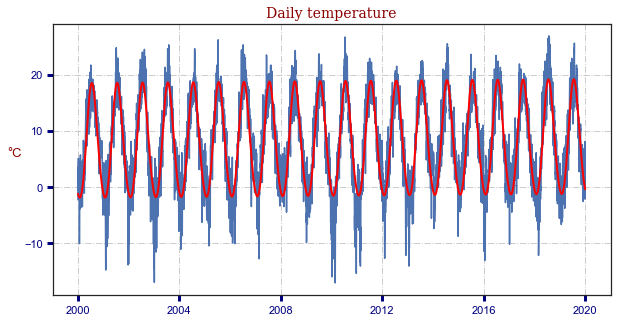

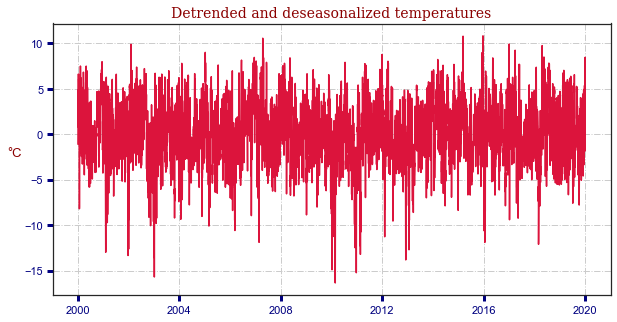

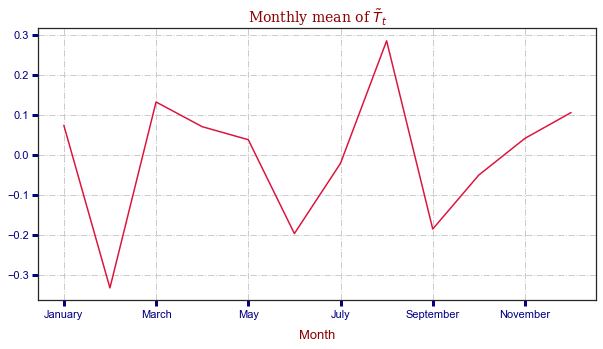

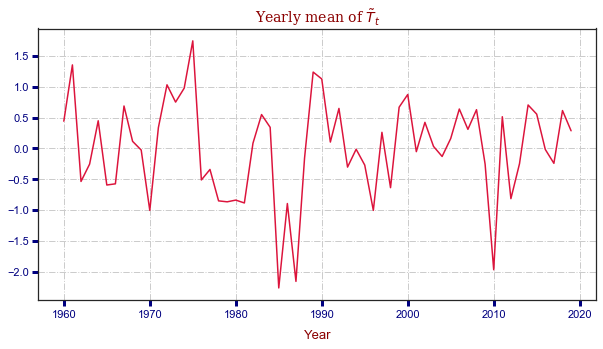

Rho = 0.8008547492405157
Kappa = 0.22207568513566173


Parameters for kappa(t)

Lambda = 0.23523671259171378
phi1 = -0.029629918020637566
varphi1 = 0.06496097376065202
phi2 = -0.036865297056646366
varphi2 = 0.26830186964048086
phi3 = 0.01633859377487671
varphi3 = 1.6017102936767609
phi4 = -0.0007695873912343463
varphi4 = 0.24609306152333735


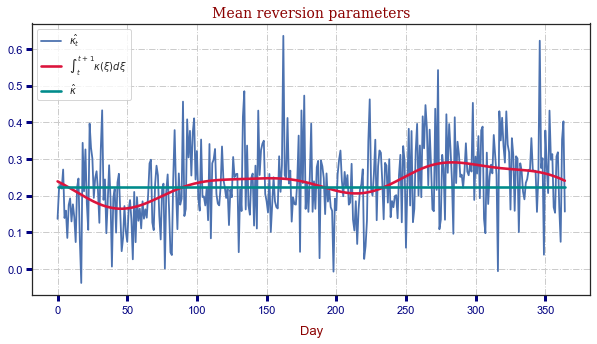

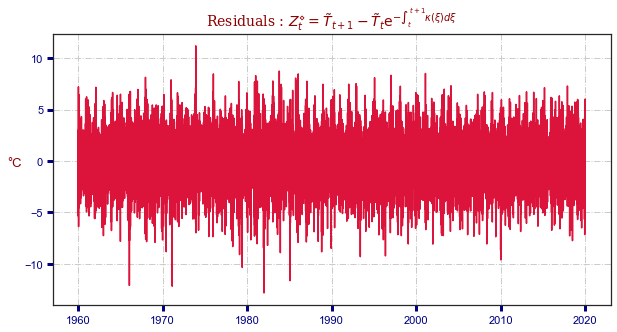

Mean of residuals $Z_t$ : -0.0005178201744842756
Std of residuals $Z_t : 2.1032657737324794


Parameters sigma(t) for W_t 

Lambda = 5.536528121723934
phi1 = 2.267267625887284
varphi1 = 1.2505497831125316
phi2 = -1.4801537100366213
varphi2 = -1.1533860842826675
phi3 = 0.6459907702278879
varphi3 = 0.8227225422652261
phi4 = -0.05130775413724097
varphi4 = -0.970003080373328


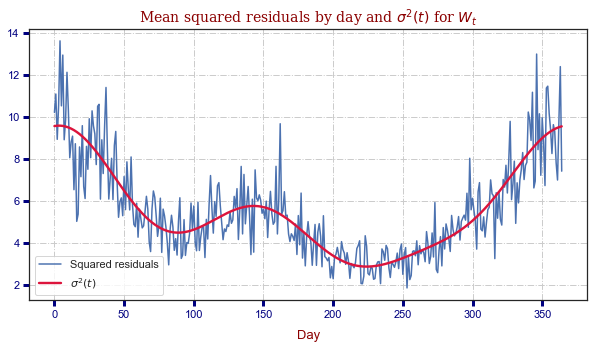

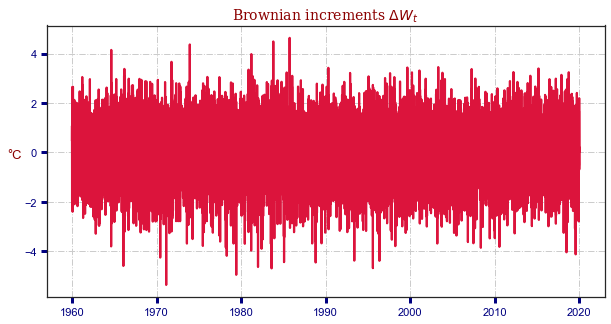

Mean of $\Delta L_t$ : 9.50295401090838e-05
Std of $\Delta L_t$ : 1.0001543033389062


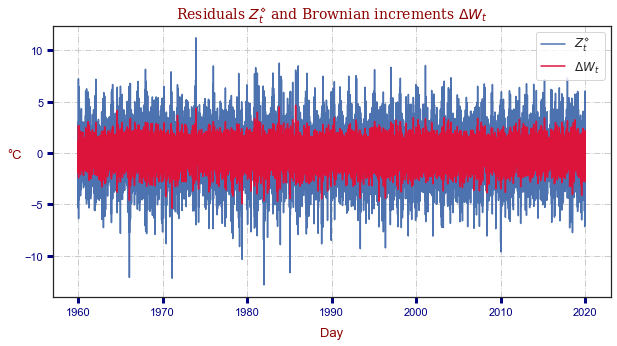

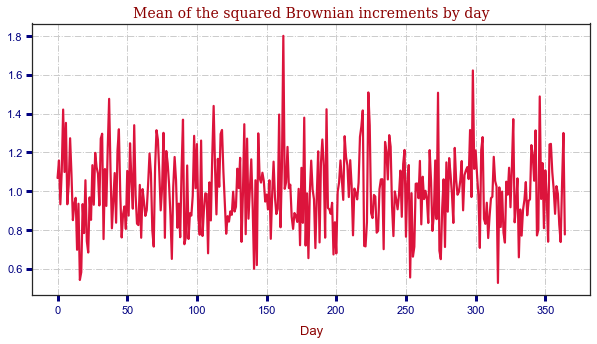

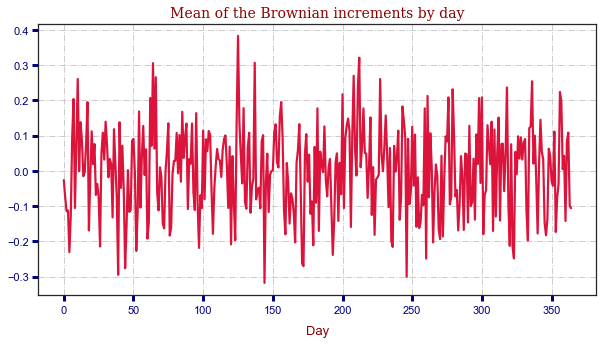

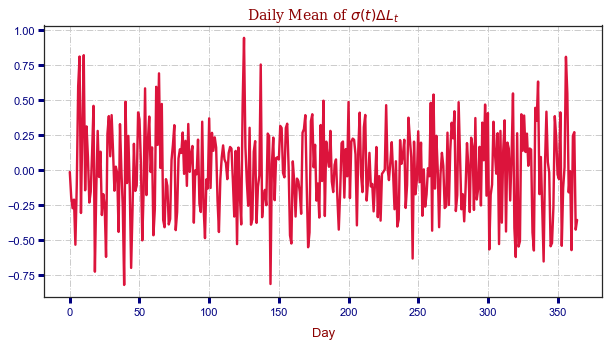



Parameters sigma(t) for L_t 

Lambda = 6.137261912748916
phi1 = 2.4610598949596327
varphi1 = 1.2648519932150053
phi2 = -1.6420730958940173
varphi2 = -1.1105401910897663
phi3 = 0.6901859440955523
varphi3 = 0.8159967383683336
phi4 = -0.0859968526532975
varphi4 = -0.7976238695231654


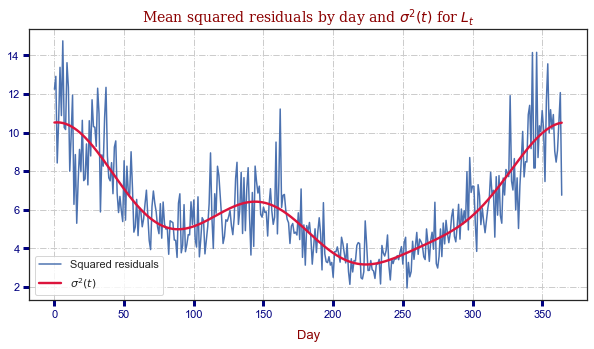

Mean of Deseasonalized residuals DeltaL_t: 3.440865362780685e-05
Std of Deseasonalized residuals DeltaL_t: 1.0001864337734065


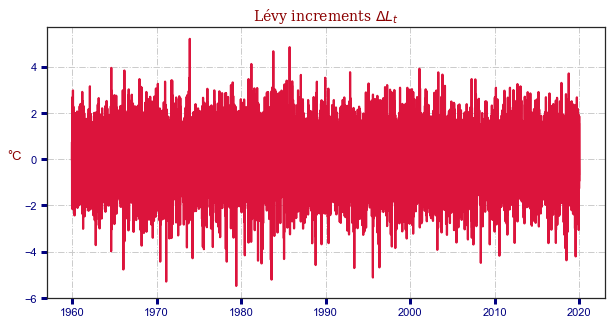

Mean of $\Delta L_t$ : 3.440865362780685e-05
Std of $\Delta L_t$ : 1.0001864337734065


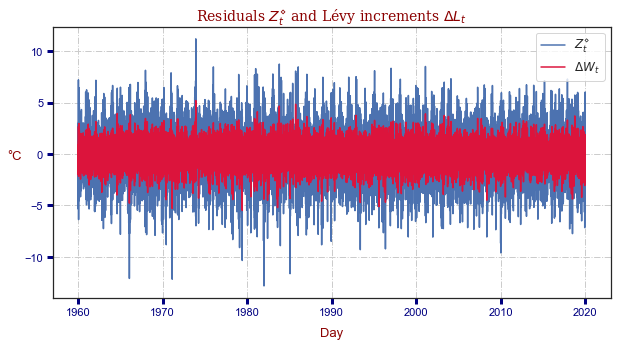

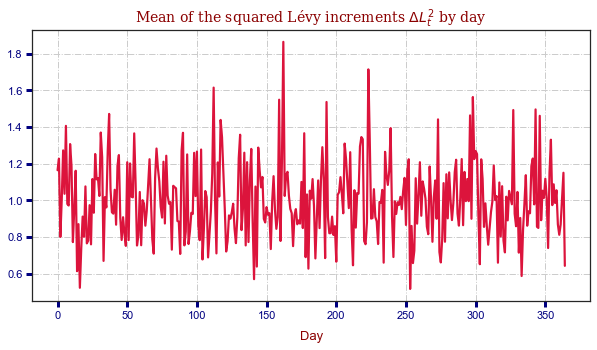

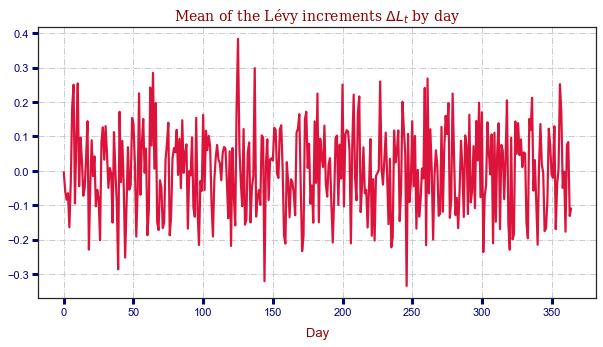

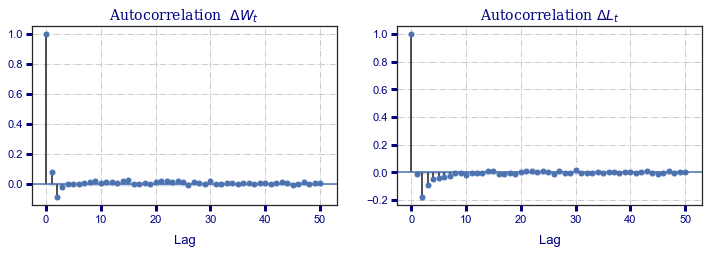

Fit Lévy : 




C:\Users\nicol\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


GH parameters: 
 

       lambda     alpha     delta      beta   mu
GH   2.954556  2.442374  0.190832  0.000119  0.0
NIG -0.500000  1.618664  1.621384 -0.000062  0.0
HYP  1.000000  1.985415  1.173791  0.000010  0.0
VG   3.021098  2.459503  0.000000 -0.000062  0.0


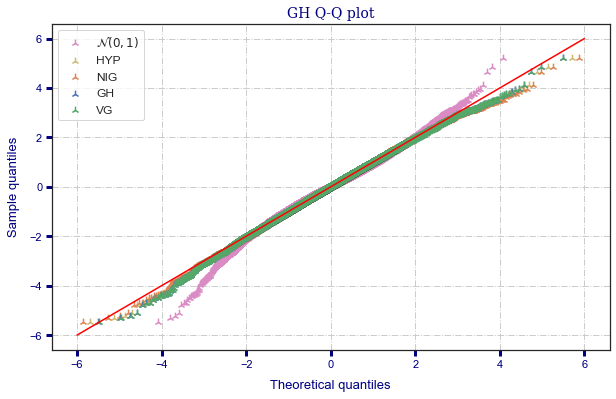

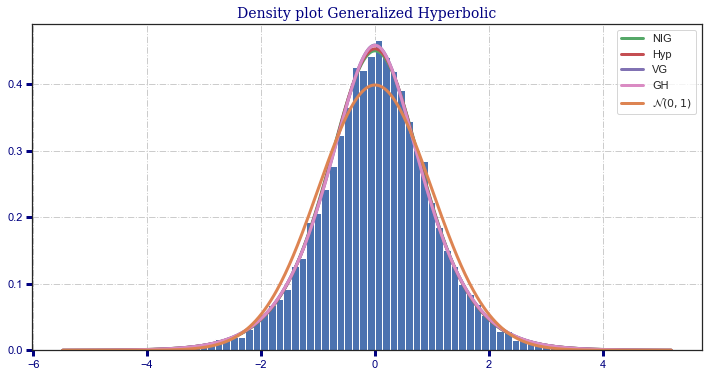

Fit gaussian : 
 



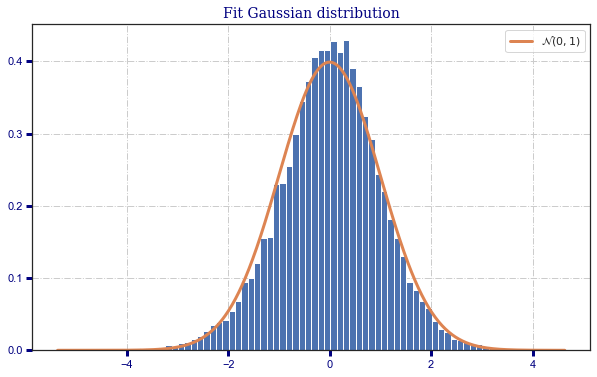

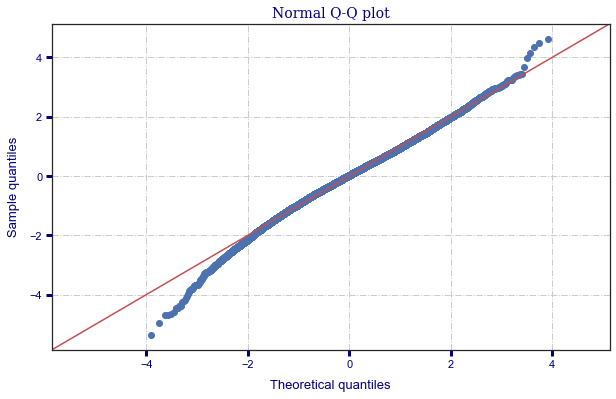

In [10]:
Model2 = Stockholm.Fit((1960,2019), (2000,2019), False)



Parameters for S(t)

a = 6.1785162890049445
b = 9.842711993555477e-05
c = 10.17684885383261
phi = -1.9358915022293823
d = -0.7672813386695645
phi2 = 29.623776422246006
Mean of Detrended and Deseasonalized temperatures TildeT_t: -1.0581379149853694e-10
Std of Detrended and Deseasonalized temperatures TildeT_t: 3.5145340538553915


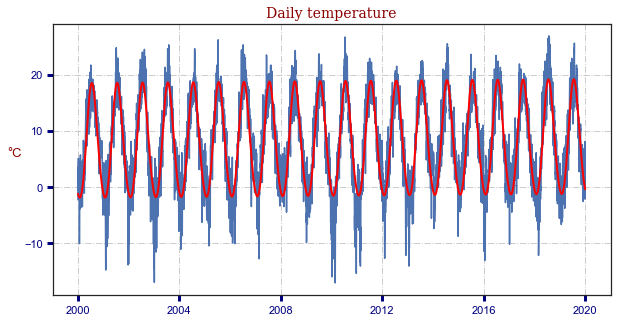

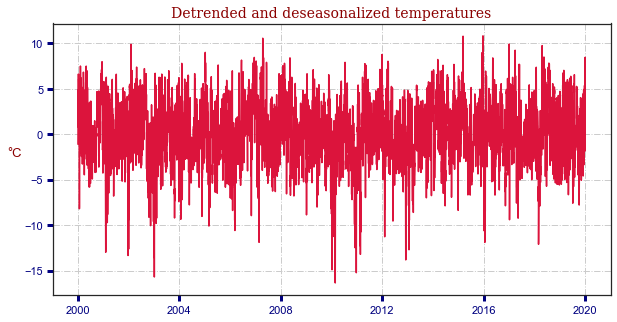

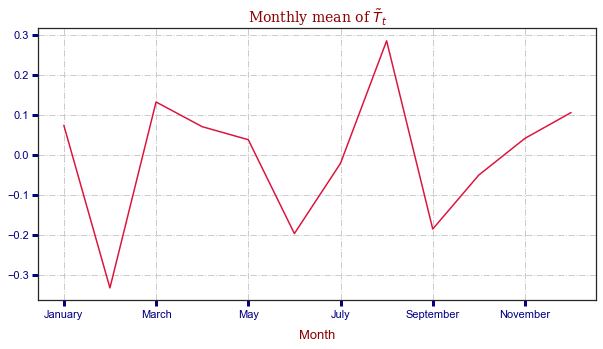

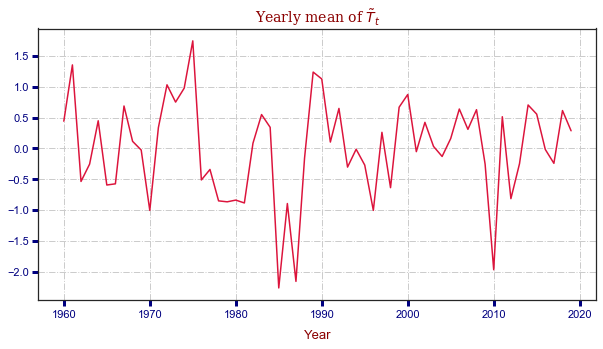

Rho = 0.8008547492405157
Kappa = 0.22207568513566173


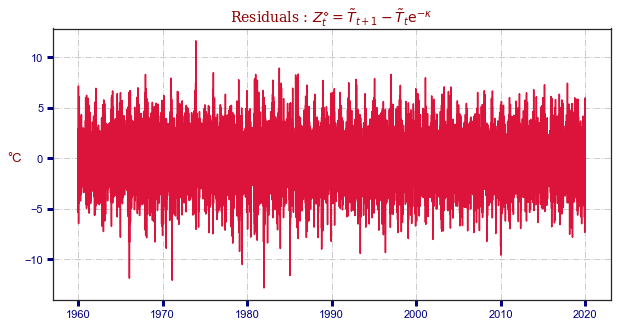

Mean of residuals $Z_t$ : -0.0001357051378799141
Std of residuals $Z_t : 2.1047385369231204


Parameters sigma(t) for W_t 

Lambda = 5.486248146862906
phi1 = 2.3236689385407727
varphi1 = 1.19130990938617
phi2 = -1.4143798156323266
varphi2 = -1.3008889365029273
phi3 = 0.6257781999463782
varphi3 = 0.6458663557462555
phi4 = -0.02470285541993388
varphi4 = -0.9210284018231684


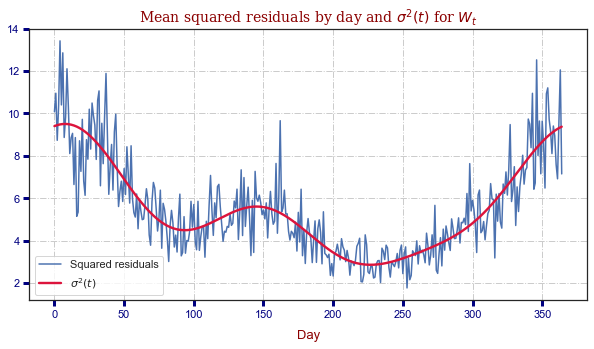

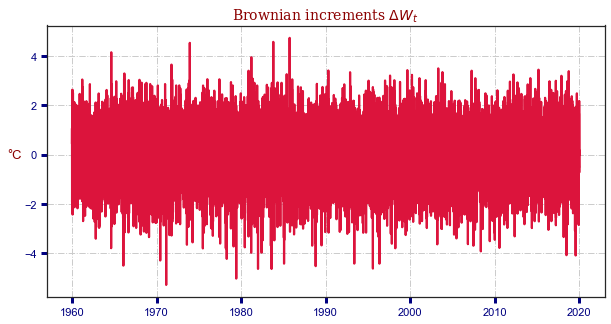

Mean of $\Delta L_t$ : 0.00045764303307804246
Std of $\Delta L_t$ : 1.0001013155850362


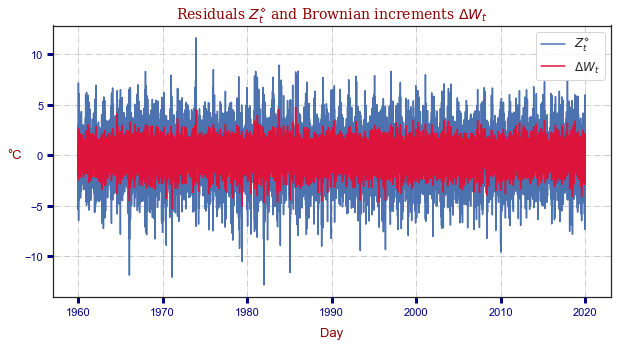

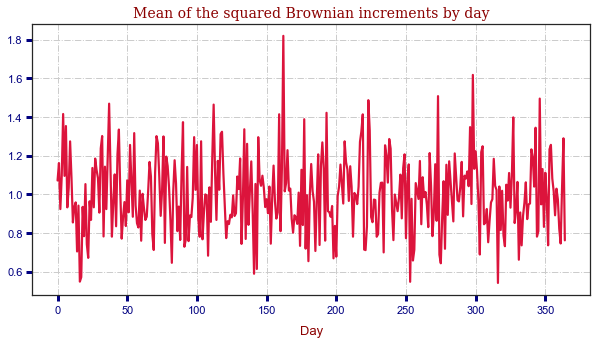

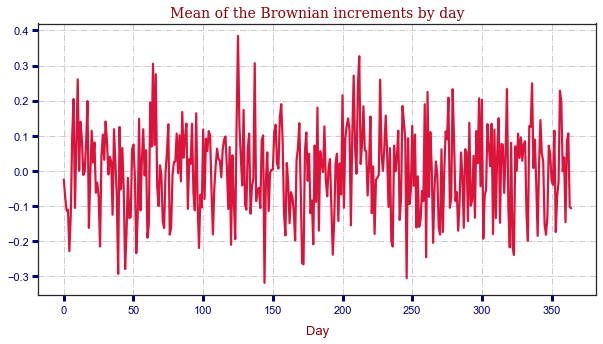

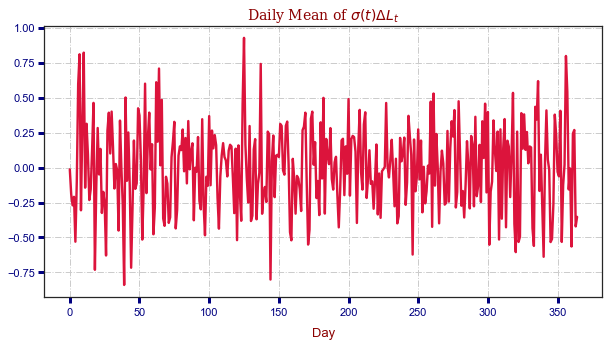



Parameters sigma(t) for L_t 

Lambda = 6.07340448175054
phi1 = 2.5125963720919233
varphi1 = 1.2048650771125153
phi2 = -1.5673162602384785
varphi2 = -1.249777056029442
phi3 = 0.6747580293367428
varphi3 = 0.6593518799507244
phi4 = -0.06116340915424446
varphi4 = -0.8975968382757149


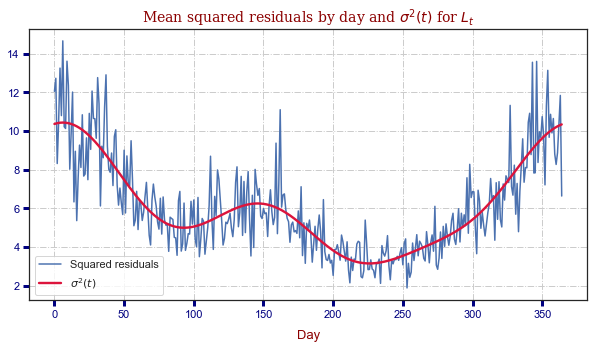

Mean of Deseasonalized residuals DeltaL_t: 2.8350171223480955e-05
Std of Deseasonalized residuals DeltaL_t: 1.0001499087383479


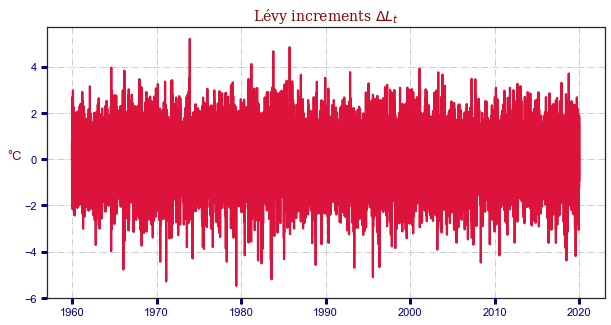

Mean of $\Delta L_t$ : 2.8350171223480955e-05
Std of $\Delta L_t$ : 1.0001499087383479


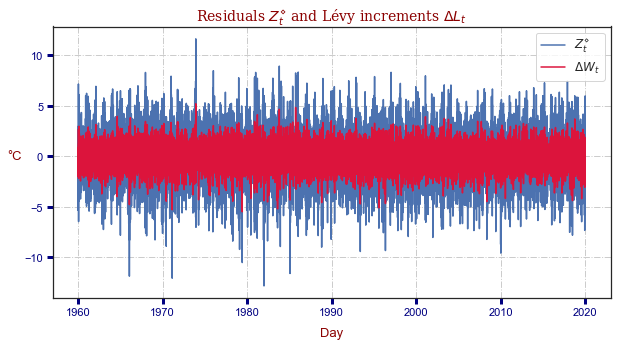

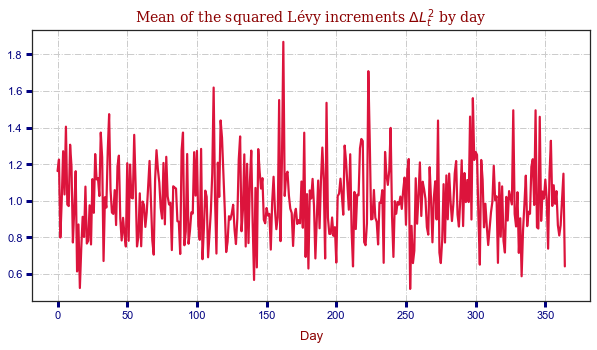

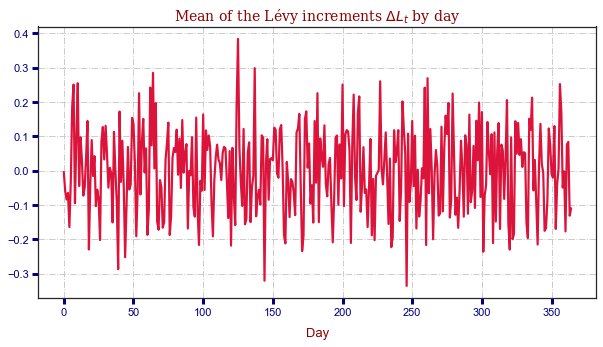

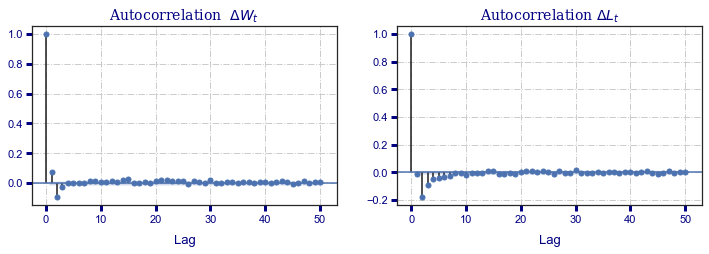

Fit Lévy : 




C:\Users\nicol\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


GH parameters: 
 

       lambda     alpha     delta      beta   mu
GH   2.953263  2.442156  0.193215  0.000015  0.0
NIG -0.500000  1.618144  1.620796  0.000028  0.0
HYP  1.000000  1.986294  1.175125 -0.000012  0.0
VG   3.003475  2.451575  0.000000 -0.000556  0.0


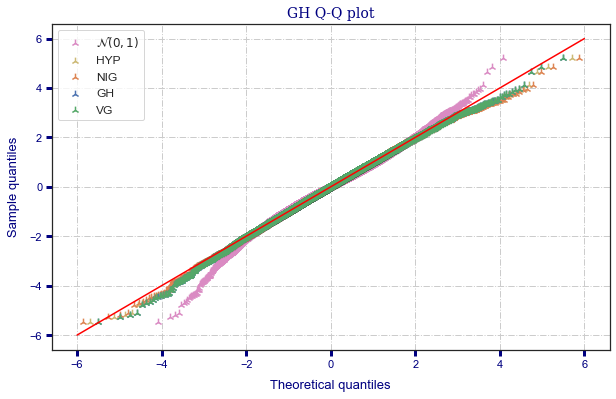

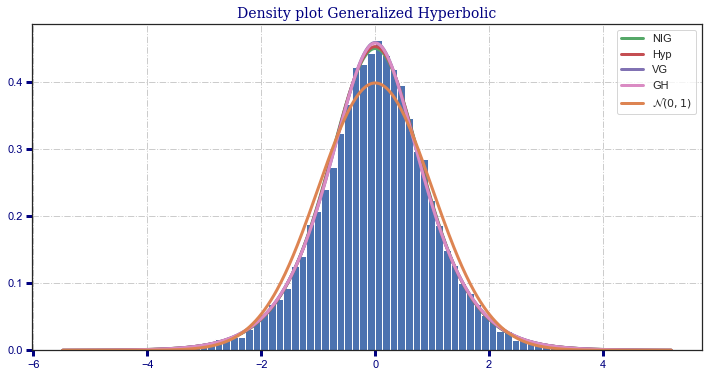

Fit gaussian : 
 



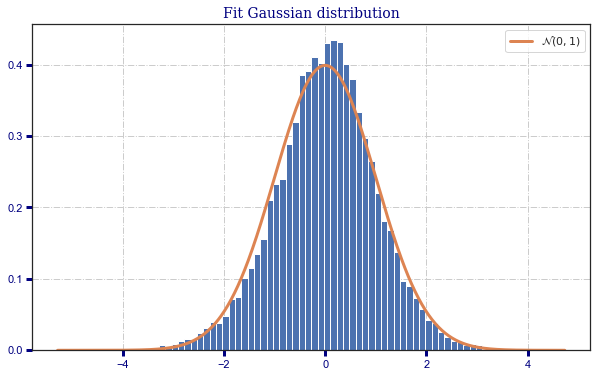

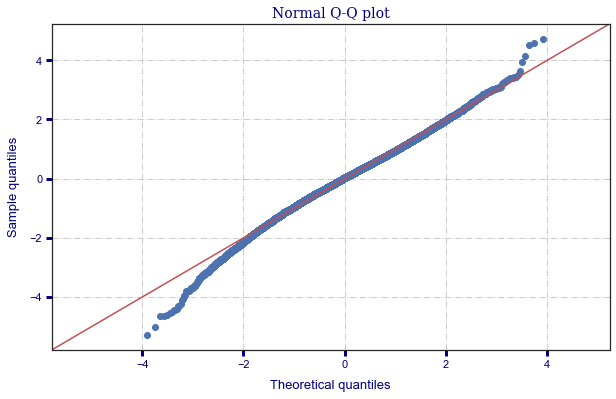

In [11]:
Model3 = Stockholm.Fit((1960,2019), (2000,2019), True)

In [217]:
def GenPricingParam(Model, StartDate, EndDate):
    StartDate = pd.to_datetime(StartDate, format='%d/%m/%Y')
    PreviousDate = StartDate - pd.Timedelta('1 days')
    EndDate = pd.to_datetime(EndDate, format='%d/%m/%Y')
    t = Model.loc[StartDate, 'N']
    PrintStr = "The first day of the contract correspond to t = {}\n"
    print(PrintStr.format(str(t)))
    InitialDiff = Model.loc[PreviousDate, 'Detrended']
    PrintStr = "On the previous day, T_t - S(t) = {} \n"
    print(PrintStr.format(str(InitialDiff)))
    TimeDiff = EndDate - StartDate
    NumberOfDays = TimeDiff.days + 1
    PrintStr = "The maturity of the contract is {} days.\n"
    print(PrintStr.format(str(NumberOfDays)))
    return t, InitialDiff, NumberOfDays

#Same initial difference for all models only need to run it once
#check if last day is included


In [218]:
@njit
def PricingVG(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Kappa(t):
        omega = 2*np.pi/365.0
        Lambda = 0.23523671259171378
        phi1 = -0.029629918020637566
        varphi1 = 0.06496097376065202
        phi2 = -0.036865297056646366
        varphi2 = 0.26830186964048086
        phi3 = 0.01633859377487671
        varphi3 = 1.6017102936767609
        phi4 = -0.0007695873912343463
        varphi4 = 0.24609306152333735
        return Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4)
    def Sigma(t):
        omega = 2*np.pi/365.0
        Lambda = 6.137261912748916
        phi1 = 2.4610598949596327
        varphi1 = 1.2648519932150053
        phi2 = -1.6420730958940173
        varphi2 = -1.1105401910897663
        phi3 = 0.6901859440955523
        varphi3 = 0.8159967383683336
        phi4 = -0.0859968526532975
        varphi4 = -0.7976238695231654
        return np.sqrt(Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4))
    def Sim():
        #param
        Lambda = 3.021098
        alpha = 2.459503
        beta = -0.000062
        N = Maturity*nDailySteps
        #final value of the index for each sim
        CatValues = np.zeros(nSim)
        HDDValues = np.zeros(nSim)
        CDDValues = np.zeros(nSim)
        #Constant for each sim --> compute them only once
        vS = np.zeros(shape = N + 1)
        vKappa = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vKappa[i] = Kappa(t + i*dT)
            vSigma[i] = Sigma(t + i*dT)
        #Individual simulations.
        for i in prange(nSim):
            TildeT = np.zeros(shape = N + 1)
            TildeT[0] = InitialDiff
            Norm = np.random.normal(loc=0.0, scale=1.0, size=N)
            Gam = np.random.gamma(shape = Lambda*dT, scale = 2/(alpha**2 - beta**2), size=N)
            for z in range(N):
                TildeT[z + 1] =  TildeT[z] - vKappa[z]*TildeT[z]*dT + vSigma[z] * (beta * Gam[z] + np.sqrt(Gam[z]) * Norm[z])
            Tt = TildeT + vS
            print(Tt)
            print(TildeT)
            print(vS)
            #We have the temperature path for that sim
            #Compute DAT for each day
            #then compute value of the index
            CAT = np.zeros(shape = Maturity)
            HDD = np.zeros(shape = Maturity)
            CDD = np.zeros(shape = Maturity)
            for z in range(0, Maturity):
                position = z*nDailySteps
                DailyTemp = (Tt[(1+position):(1+position+nDailySteps)].max() + Tt[(1+position):(1+position+nDailySteps)].min())/2
                CAT[z] = DailyTemp
                HDD[z] = max(18 - DailyTemp, 0)
                CDD[z] = max(DailyTemp - 18, 0)
            CatValues[i] = CAT.sum()
            HDDValues[i] = HDD.sum()
            CDDValues[i] = CDD.sum()
        Indexes = CatValues, HDDValues, CDDValues
        return Indexes
    return Sim()

In [219]:
@njit
def PricingVGConst(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    Kappa = 0.22207568513566173
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Sigma(t):
        omega = 2*np.pi/365.0
        Lambda = 6.07340448175054
        phi1 = 2.5125963720919233
        varphi1 = 1.2048650771125153
        phi2 = -1.5673162602384785
        varphi2 = -1.249777056029442
        phi3 = 0.6747580293367428
        varphi3 = 0.6593518799507244
        phi4 = -0.06116340915424446
        varphi4 = -0.8975968382757149
        return np.sqrt(Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4))
    def Sim():
        #param
        Lambda = 3.003475
        alpha = 2.451575
        beta = -0.000556 
        N = Maturity*nDailySteps
        #final value of the index for each sim
        CatValues = np.zeros(nSim)
        HDDValues = np.zeros(nSim)
        CDDValues = np.zeros(nSim)
        #Constant for each sim --> compute them only once
        vS = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vSigma[i] = Sigma(t + i*dT)
        #Individual simulations.
        for i in prange(nSim):
            TildeT = np.zeros(shape = N + 1)
            TildeT[0] = InitialDiff
            Norm = np.random.normal(loc=0.0, scale=1.0, size=N)
            Gam = np.random.gamma(shape = Lambda*dT, scale = 2/(alpha**2 - beta**2), size=N)
            for z in range(N):
                TildeT[z + 1] = TildeT[z] - Kappa*TildeT[z]*dT + vSigma[z] * (beta*Gam[z] + np.sqrt(Gam[z]) * Norm[z])
            Tt = TildeT + vS
            #We have the temperature path for that sim
            #Compute DAT for each day
            #then compute value of the index
            CAT = np.zeros(shape = Maturity)
            HDD = np.zeros(shape = Maturity)
            CDD = np.zeros(shape = Maturity)
            for z in range(0, Maturity):
                position = z*nDailySteps
                DailyTemp = (Tt[(1+position):(1+position+nDailySteps)].max() + Tt[(1+position):(1+position+nDailySteps)].min())/2
                CAT[z] = DailyTemp
                HDD[z] = max(18 - DailyTemp, 0)
                CDD[z] = max(DailyTemp - 18, 0)
            CatValues[i] = CAT.sum()
            HDDValues[i] = HDD.sum()
            CDDValues[i] = CDD.sum()
        Indexes = CatValues, HDDValues, CDDValues
        return Indexes
    return Sim()

In [ ]:
@njit
def PricingNIG(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Kappa(t):
        omega = 2*np.pi/365.0
        Lambda = 0.23523671259171378
        phi1 = -0.029629918020637566
        varphi1 = 0.06496097376065202
        phi2 = -0.036865297056646366
        varphi2 = 0.26830186964048086
        phi3 = 0.01633859377487671
        varphi3 = 1.6017102936767609
        phi4 = -0.0007695873912343463
        varphi4 = 0.24609306152333735
        return Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4)
    def Sigma(t):
        omega = 2*np.pi/365.0
        Lambda = 6.137261912748916
        phi1 = 2.4610598949596327
        varphi1 = 1.2648519932150053
        phi2 = -1.6420730958940173
        varphi2 = -1.1105401910897663
        phi3 = 0.6901859440955523
        varphi3 = 0.8159967383683336
        phi4 = -0.0859968526532975
        varphi4 = -0.7976238695231654
        return np.sqrt(Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4))
    def Sim():
        #param
        alpha = 1.618664
        beta = -0.000062
        delta =  1.621384
        #Want to run 
        N = Maturity*nDailySteps
        #final value of the index for each sim
        CatValues = np.zeros(nSim)
        HDDValues = np.zeros(nSim)
        CDDValues = np.zeros(nSim)
        #Constant for each sim --> compute them only once
        vS = np.zeros(shape = N + 1)
        vKappa = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vKappa[i] = Kappa(t + i*dT)
            vSigma[i] = Sigma(t + i*dT)
        #Individual simulations.
        for i in prange(nSim):
            TildeT = np.zeros(shape = N + 1)
            TildeT[0] = InitialDiff
            Norm = np.random.normal(loc=0.0, scale=1.0, size=N)
            #note conversion to numpy implementation(wald)
            #scale = lambda = delta**2 --> (delta*dt)**2
            #mean = mu = delta/gamma ----> delta*dt/sqrt(alpha**2 - beta**2)
            NIG = np.random.wald(mean = (delta*dT)**2, scale = delta*dT/np.sqrt(alpha**2 - beta**2), size=N)
            for z in range(N):
                TildeT[z + 1] =  TildeT[z] - vKappa[z]*TildeT[z]*dT + vSigma[z] * (beta * NIG[z] + np.sqrt(NIG[z]) * Norm[z])
            Tt = TildeT + vS
            print(Tt)
            print(TildeT)
            print(vS)
            #We have the temperature path for that sim
            #Compute DAT for each day
            #then compute value of the index
            CAT = np.zeros(shape = Maturity)
            HDD = np.zeros(shape = Maturity)
            CDD = np.zeros(shape = Maturity)
            for z in range(0, Maturity):
                position = z*nDailySteps
                DailyTemp = (Tt[(1+position):(1+position+nDailySteps)].max() + Tt[(1+position):(1+position+nDailySteps)].min())/2
                CAT[z] = DailyTemp
                HDD[z] = max(18 - DailyTemp, 0)
                CDD[z] = max(DailyTemp - 18, 0)
            CatValues[i] = CAT.sum()
            HDDValues[i] = HDD.sum()
            CDDValues[i] = CDD.sum()
        Indexes = CatValues, HDDValues, CDDValues
        return Indexes
    return Sim()

In [ ]:
@njit
def PricingNIGConst(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    Kappa = 0.22207568513566173
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Sigma(t):
        omega = 2*np.pi/365.0
        Lambda = 6.07340448175054
        phi1 = 2.5125963720919233
        varphi1 = 1.2048650771125153
        phi2 = -1.5673162602384785
        varphi2 = -1.249777056029442
        phi3 = 0.6747580293367428
        varphi3 = 0.6593518799507244
        phi4 = -0.06116340915424446
        varphi4 = -0.8975968382757149
        return np.sqrt(Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4))
    def Sim():
        #param
        alpha = 1.618144
        beta = 0.000028
        delta =  1.620796
        N = Maturity*nDailySteps
        #final value of the index for each sim
        CatValues = np.zeros(nSim)
        HDDValues = np.zeros(nSim)
        CDDValues = np.zeros(nSim)
        #Constant for each sim --> compute them only once
        vS = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vSigma[i] = Sigma(t + i*dT)
        #Individual simulations.
        for i in prange(nSim):
            TildeT = np.zeros(shape = N + 1)
            TildeT[0] = InitialDiff
            Norm = np.random.normal(loc=0.0, scale=1.0, size=N)
            #note conversion to numpy implementation(wald)
            #scale = lambda = delta**2 --> (delta*dt)**2
            #mean = mu = delta/gamma ----> delta*dt/sqrt(alpha**2 - beta**2)
            NIG = np.random.wald(mean = (delta*dT)**2, scale = delta*dT/np.sqrt(alpha**2 - beta**2), size=N)
            for z in range(N):
                TildeT[z + 1] = TildeT[z] - Kappa*TildeT[z]*dT + vSigma[z] * (beta * NIG[z] + np.sqrt(NIG[z]) * Norm[z])
            Tt = TildeT + vS
            #We have the temperature path for that sim
            #Compute DAT for each day
            #then compute value of the index
            CAT = np.zeros(shape = Maturity)
            HDD = np.zeros(shape = Maturity)
            CDD = np.zeros(shape = Maturity)
            for z in range(0, Maturity):
                position = z*nDailySteps
                DailyTemp = (Tt[(1+position):(1+position+nDailySteps)].max() + Tt[(1+position):(1+position+nDailySteps)].min())/2
                CAT[z] = DailyTemp
                HDD[z] = max(18 - DailyTemp, 0)
                CDD[z] = max(DailyTemp - 18, 0)
            CatValues[i] = CAT.sum()
            HDDValues[i] = HDD.sum()
            CDDValues[i] = CDD.sum()
        Indexes = CatValues, HDDValues, CDDValues
        return Indexes
    return Sim()

In [220]:
@njit
def PricingBM(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Kappa(t):
        omega = 2*np.pi/365.0
        Lambda = 0.23523671259171378
        phi1 = -0.029629918020637566
        varphi1 = 0.06496097376065202
        phi2 = -0.036865297056646366
        varphi2 = 0.26830186964048086
        phi3 = 0.01633859377487671
        varphi3 = 1.6017102936767609
        phi4 = -0.0007695873912343463
        varphi4 = 0.24609306152333735
        return Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4)
    def Sigma(t):
        omega = 2*np.pi/365.0
        Lambda = 5.536528121723934
        phi1 = 2.267267625887284
        varphi1 = 1.2505497831125316
        phi2 = -1.4801537100366213
        varphi2 = -1.1533860842826675
        phi3 = 0.6459907702278879
        varphi3 = 0.8227225422652261
        phi4 = -0.05130775413724097
        varphi4 = -0.970003080373328
        return np.sqrt(Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4))
    def Sim():
        #param
        N = Maturity*nDailySteps
        #final value of the index for each sim
        CatValues = np.zeros(nSim)
        HDDValues = np.zeros(nSim)
        CDDValues = np.zeros(nSim)
        #Constant for each sim --> compute them only once
        vS = np.zeros(shape = N + 1)
        vKappa = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vKappa[i] = Kappa(t + i*dT)
            vSigma[i] = Sigma(t + i*dT)
        #Individual simulations.
        for i in prange(nSim):
            TildeT = np.zeros(shape = N + 1)
            TildeT[0] = InitialDiff
            Norm = np.random.normal(loc=0.0, scale=1.0, size=N)
            for z in range(N):
                TildeT[z + 1] = TildeT[z] - vKappa[z]*TildeT[z] * dT + vSigma[z] * np.sqrt(dT) * Norm[z]
            Tt = TildeT + vS
            #We have the temperature path for that sim
            #Compute DAT for each day
            #then compute value of the index
            CAT = np.zeros(shape = Maturity)
            HDD = np.zeros(shape = Maturity)
            CDD = np.zeros(shape = Maturity)
            for z in range(0, Maturity):
                position = z*nDailySteps
                DailyTemp = (Tt[(1+position):(1+position+nDailySteps)].max() + Tt[(1+position):(1+position+nDailySteps)].min())/2
                CAT[z] = DailyTemp
                HDD[z] = max(18 - DailyTemp, 0)
                CDD[z] = max(DailyTemp - 18, 0)
            CatValues[i] = CAT.sum()
            HDDValues[i] = HDD.sum()
            CDDValues[i] = CDD.sum()
        Indexes = CatValues, HDDValues, CDDValues
        return Indexes
    return Sim()

In [221]:
@njit
def PricingBMConst(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    Kappa = 0.22207568513566173
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Sigma(t):
        omega = 2*np.pi/365.0
        Lambda = 5.486248146862906
        phi1 = 2.3236689385407727
        varphi1 = 1.19130990938617
        phi2 = -1.4143798156323266
        varphi2 = -1.3008889365029273
        phi3 = 0.6257781999463782
        varphi3 = 0.6458663557462555
        phi4 = -0.02470285541993388
        varphi4 = -0.9210284018231684
        return np.sqrt(Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4))
    def Sim():
        #param
        N = Maturity*nDailySteps
        #final value of the index for each sim
        CatValues = np.zeros(nSim)
        HDDValues = np.zeros(nSim)
        CDDValues = np.zeros(nSim)
        #Constant for each sim --> compute them only once
        vS = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vSigma[i] = Sigma(t + i*dT)
        #Individual simulations.
        for i in prange(nSim):
            TildeT = np.zeros(shape = N + 1)
            TildeT[0] = InitialDiff
            Norm = np.random.normal(loc=0.0, scale=1.0, size=N)
            Gam = np.random.gamma(shape = Lambda*dT, scale = 2/(alpha**2 - beta**2), size=N)
            for z in range(N):
                TildeT[z + 1] = TildeT[z] - Kappa*TildeT[z]*dT + vSigma[z] * np.sqrt(dT) * Norm[z]
            Tt = TildeT + vS
            #We have the temperature path for that sim
            #Compute DAT for each day
            #then compute value of the index
            CAT = np.zeros(shape = Maturity)
            HDD = np.zeros(shape = Maturity)
            CDD = np.zeros(shape = Maturity)
            for z in range(0, Maturity):
                position = z*nDailySteps
                DailyTemp = (Tt[(1+position):(1+position+nDailySteps)].max() + Tt[(1+position):(1+position+nDailySteps)].min())/2
                CAT[z] = DailyTemp
                HDD[z] = max(18 - DailyTemp, 0)
                CDD[z] = max(DailyTemp - 18, 0)
            CatValues[i] = CAT.sum()
            HDDValues[i] = HDD.sum()
            CDDValues[i] = CDD.sum()
        Indexes = CatValues, HDDValues, CDDValues
        return Indexes
    return Sim()

In [307]:
def Results(Arrs, Type, period):
    #Plot CAT
    g = plt.figure(figsize=(12,6))
    sns.kdeplot(Arrs[0], shade=False, label = 'Model1', linewidth = 2, color = 'C2')
    sns.kdeplot(Arrs[1], shade=False, label = 'Model2', linewidth = 2, color = 'C3')
    sns.kdeplot(Arrs[2], shade=False, label = 'Model3', linewidth = 2, color = 'C4')
    sns.kdeplot(Arrs[3], shade=False, label = 'Model4', linewidth = 2, color = 'C1')
    plt.title('Density Plot ' + Type + ' ' + period, fontdict = font2)
    plt.xlabel(Type, color='Navy', size = 13, labelpad=10)
    plt.ylabel('Density', color='Navy', size = 13, labelpad=10)
    plt.legend(fontsize = 'x-large')
    plt.savefig('C:/Users/nicol/Dropbox/Mémoire/Tempfig/Density'+ Type + period + '.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    #Value of the Future
    print('Value of the Future for Model1 : ' + str(Arrs[0].mean()))
    print('Value of the Future for Model2 : ' + str(Arrs[1].mean()))
    print('Value of the Future for Model3 : ' + str(Arrs[2].mean()))
    print('Value of the Future for Model4 : ' + str(Arrs[3].mean()))
    #Value of the Option
    MaxVal = max(np.max(Arrs[0]), np.max(Arrs[1]), np.max(Arrs[2]), np.max(Arrs[3]))
    Strikes = np.linspace(0, MaxVal, 201)
    Call1 = np.zeros(shape = 201)
    Call2 = np.zeros(shape = 201)
    Call3 = np.zeros(shape = 201)
    Call4 = np.zeros(shape = 201)
    Put1 = np.zeros(shape = 201)
    Put2 = np.zeros(shape = 201)
    Put3 = np.zeros(shape = 201)
    Put4 = np.zeros(shape = 201)
    for i in range(201):
        Strike = Strikes[i]
        Call1[i] = np.maximum(Arrs[0] - Strike, 0).mean()
        Put1[i] = np.maximum(Strike - Arrs[0], 0).mean()
        Call2[i] = np.maximum(Arrs[1] - Strike, 0).mean()
        Put2[i] = np.maximum(Strike - Arrs[1], 0).mean()
        Call3[i] = np.maximum(Arrs[2] - Strike, 0).mean()
        Put3[i] = np.maximum(Strike - Arrs[2], 0).mean()
        Call4[i] = np.maximum(Arrs[3] - Strike, 0).mean()
        Put4[i] = np.maximum(Strike - Arrs[3], 0).mean()
    #Value of the call option plot
    g = plt.figure(figsize=(12,6))
    plt.plot(Strikes, Call1, label = 'Model1', linewidth = 2, color = 'C2')
    plt.plot(Strikes, Call2, label = 'Model2', linewidth = 2, color = 'C3')
    plt.plot(Strikes, Call3, label = 'Model3', linewidth = 2, color = 'C4')
    plt.plot(Strikes, Call4, label = 'Model4', linewidth = 2, color = 'C1')
    plt.title('Value of the Call as a function of the Strike', fontdict = font2)
    plt.xlabel('Strike', color='Navy', size = 13, labelpad=10)
    plt.ylabel('Value', color='Navy', size = 13, labelpad=10)
    plt.legend(fontsize = 'x-large')
    plt.savefig('C:/Users/nicol/Dropbox/Mémoire/Tempfig/Call'+ Type + period + '.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    #Value of the Put option plot
    g = plt.figure(figsize=(12,6))
    plt.plot(Strikes, Put1, label = 'Model1', linewidth = 2, color = 'C2')
    plt.plot(Strikes, Put2, label = 'Model2', linewidth = 2, color = 'C3')
    plt.plot(Strikes, Put3, label = 'Model3', linewidth = 2, color = 'C4')
    plt.plot(Strikes, Put4, label = 'Model4', linewidth = 2, color = 'C1')
    plt.title('Value of the Put as a function of the Strike', fontdict = font2)
    plt.xlabel('Strike', color='Navy', size = 13, labelpad=10)
    plt.ylabel('Value', color='Navy', size = 13, labelpad=10)
    plt.legend(fontsize = 'x-large')
    plt.savefig('C:/Users/nicol/Dropbox/Mémoire/Tempfig/Put'+ Type + period + '.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    #Quantiles
    print('Value of the quantiles [0.001, 0.005, 0.01, 0.99, 0.995, 0.999] : \n')
    print('Model 1 : ')
    print(np.quantile(a = Arrs[0], q = [0.001, 0.005, 0.01, 0.99, 0.995, 0.999]))
    print('Model 2 : ')
    print(np.quantile(a = Arrs[1], q =[0.001, 0.005, 0.01, 0.99, 0.995, 0.999]))
    print('Model 3 : ')
    print(np.quantile(a = Arrs[2], q = [0.001, 0.005, 0.01, 0.99, 0.995, 0.999]))
    print('Model 4 : ')
    print(np.quantile(a = Arrs[3], q =[0.001, 0.005, 0.01, 0.99, 0.995, 0.999]))
    return None

In [247]:
#Contract Feb 
t, InitialDiff, NumberOfDays = GenPricingParam(Model2, '01/02/2019', '28/02/2019')

The first day of the contract correspond to t = 21567

On the previous day, T_t - S(t) = -0.877290606124236 

The maturity of the contract is 28 days.



In [230]:
#Feb
#GH + kappa(t)
Result5 = PricingVG(t = 21567, Maturity = 28, InitialDiff = -0.877290606124236  , nDailySteps = 100, nSim = 200000)
CatValues5, HDDValues5, CDDValues5 = Result5


#GH + kappa
Result6 = PricingVGConst(t = 21567, Maturity = 28, InitialDiff = -0.877290606124236  , nDailySteps = 100, nSim = 200000)
CatValues6, HDDValues6, CDDValues6 = Result6


#BM + kappa(t)
Result7 = PricingBM(t = 21567, Maturity = 28, InitialDiff =-0.877290606124236  , nDailySteps = 100, nSim = 200000)
CatValues7, HDDValues7, CDDValues7 = Result7


#BM + kappa
Result8 = PricingBMConst(t = 21567, Maturity = 28, InitialDiff = -0.877290606124236  , nDailySteps = 100, nSim = 200000)
CatValues8, HDDValues8, CDDValues8 = Result8

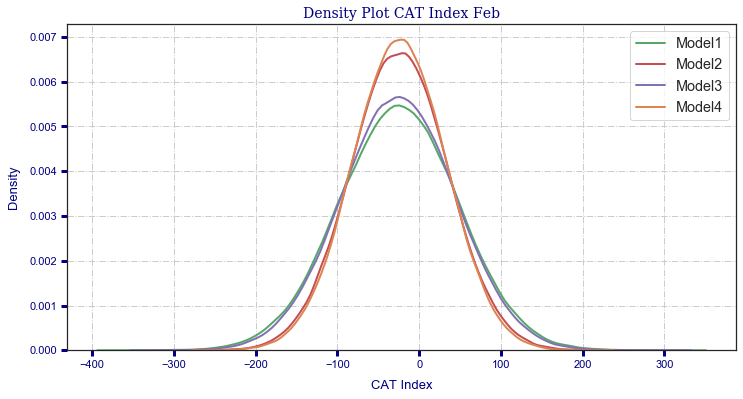

Value of the Future for Model1 : -25.120625881936643
Value of the Future for Model2 : -24.350675878251298
Value of the Future for Model3 : -25.19547793576081
Value of the Future for Model4 : -24.161714457051467


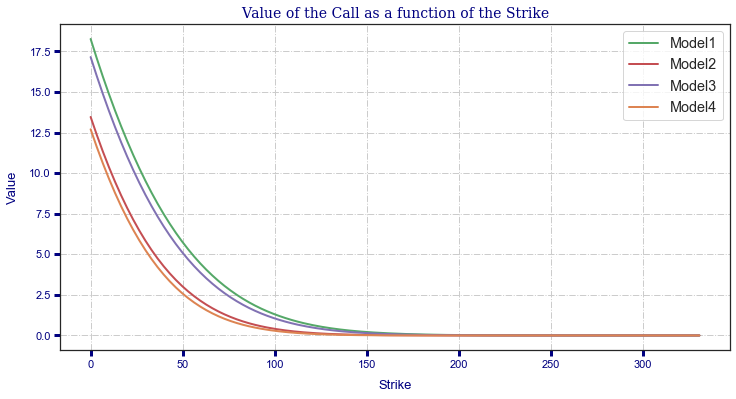

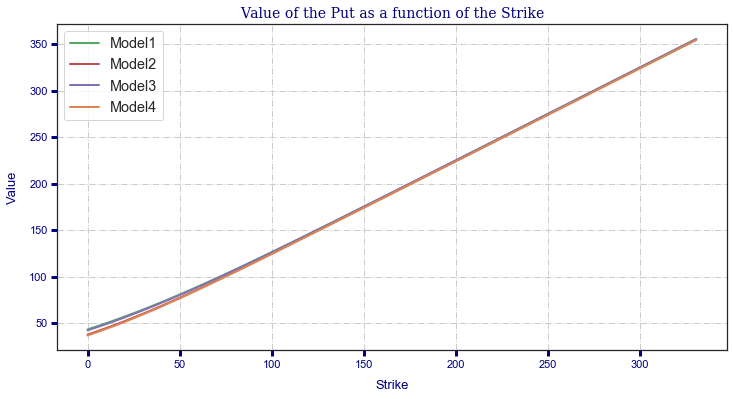

Value of the quantiles [0.001, 0.005, 0.01, 0.99, 0.995, 0.999] : 

Model 1 : 
[-252.46608798 -214.82379582 -196.49033668  144.74698393  163.66481267
  203.65531019]
Model 2 : 
[-209.04048324 -177.43425808 -162.60832875  114.50605918  129.622303
  160.70659705]
Model 3 : 
[-243.03218629 -206.54851541 -188.3170373   137.98754185  155.60614437
  193.16188503]
Model 4 : 
[-201.30614546 -171.25713559 -157.35493569  108.33642692  122.3136637
  150.16594413]


In [308]:
Results([CatValues5, CatValues6, CatValues7, CatValues8], 'CAT Index', 'Feb')

In [288]:
#Contract Sept - Nov
t, InitialDiff, NumberOfDays = GenPricingParam(Model2, '01/09/2019', '30/11/2019')

The first day of the contract correspond to t = 21779

On the previous day, T_t - S(t) = 3.0614559677297315 

The maturity of the contract is 91 days.



In [289]:
#Sept - Nov
#GH + kappa(t)
Result1 = PricingVG(t = 21779, Maturity = 91, InitialDiff = 3.0614559677297315, nDailySteps = 100, nSim = 200000)
CatValues1, HDDValues1, CDDValues1 = Result1

#GH + kappa
Result2 = PricingVGConst(t = 21779, Maturity = 91, InitialDiff = 3.0614559677297315, nDailySteps = 100, nSim = 200000)
CatValues2, HDDValues2, CDDValues2 = Result2

#BM + kappa(t)
Result3 = PricingBM(t = 21779, Maturity = 91, InitialDiff = 3.0614559677297315, nDailySteps = 100, nSim = 200000)
CatValues3, HDDValues3, CDDValues3 = Result3

#BM + kappa
Result4 = PricingBMConst(t = 21779, Maturity = 91, InitialDiff = 3.0614559677297315, nDailySteps = 100, nSim = 200000)
CatValues4, HDDValues4, CDDValues4 = Result4

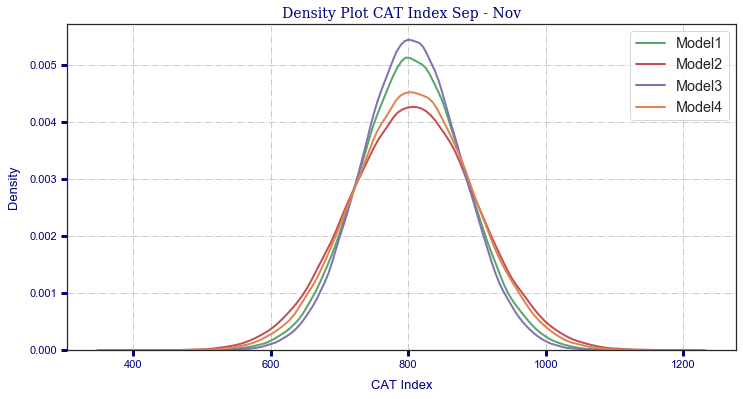

Value of the Future for Model1 : 805.7443061683846
Value of the Future for Model2 : 806.7964088289765
Value of the Future for Model3 : 805.5293278434567
Value of the Future for Model4 : 807.5454983130513


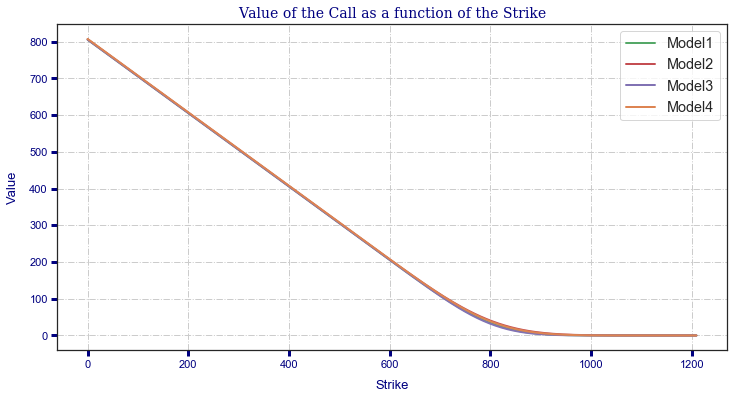

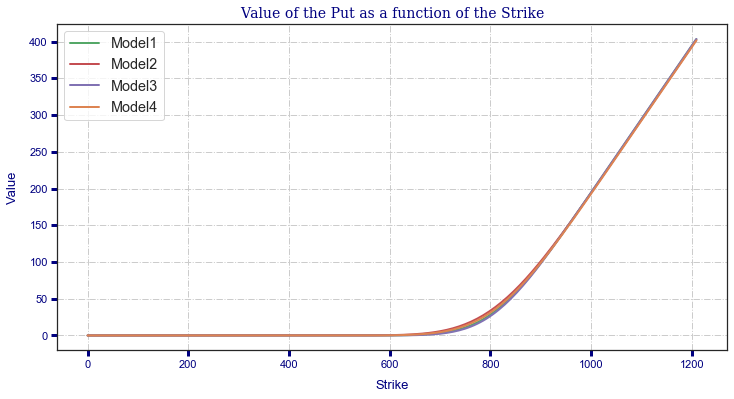

Value of the quantiles [0.001, 0.005, 0.01, 0.99, 0.995, 0.999] : 

Model 1 : 
[ 561.534541    603.33295371  622.89565186  987.9157343  1007.28036316
 1045.41746816]
Model 2 : 
[ 524.37202022  568.84962509  591.01072961 1023.88637245 1048.28134313
 1097.54364356]
Model 3 : 
[ 579.60001349  617.89561754  636.07766133  975.49301501  993.5850619
 1032.42926452]
Model 4 : 
[ 540.24392833  583.83349017  604.6943339  1009.30514304 1030.48837126
 1075.59658012]


In [309]:
Results([CatValues1, CatValues2, CatValues3, CatValues4], 'CAT Index', 'Sep - Nov')

In [293]:
#Contract Jun - Aug
t, InitialDiff, NumberOfDays = GenPricingParam(Model2, '01/06/2019', '31/08/2019')

The first day of the contract correspond to t = 21687

On the previous day, T_t - S(t) = -0.8812524168644469 

The maturity of the contract is 92 days.



In [306]:
#Jun - Aug
#GH + kappa(t)
Result9 = PricingVG(t = 21687, Maturity = 92, InitialDiff = -0.8812524168644469, nDailySteps = 100, nSim = 200000)
CatValues9, HDDValues9, CDDValues9 = Result9

#GH + kappa
Result10 = PricingVGConst(t = 21687, Maturity = 92, InitialDiff = -0.8812524168644469, nDailySteps = 100, nSim = 200000)
CatValues10, HDDValues10, CDDValues10 = Result10

#BM + kappa(t)
Result11 = PricingBM(t = 21687, Maturity = 92, InitialDiff = -0.8812524168644469, nDailySteps = 100, nSim = 200000)
CatValues11, HDDValues11, CDDValues11 = Result11

#BM + kappa
Result12 = PricingBMConst(t = 21687, Maturity = 92, InitialDiff = -0.8812524168644469, nDailySteps = 100, nSim = 200000)
CatValues12, HDDValues12, CDDValues12 = Result12

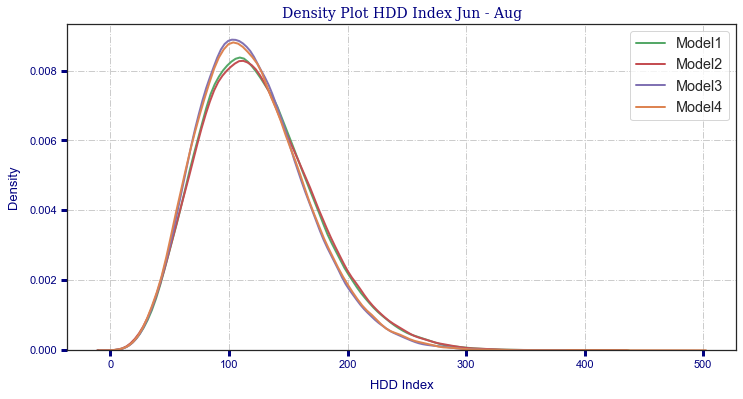

Value of the Future for Model1 : 124.2563613601051
Value of the Future for Model2 : 124.66405717310207
Value of the Future for Model3 : 119.5368785827366
Value of the Future for Model4 : 119.76971978981163


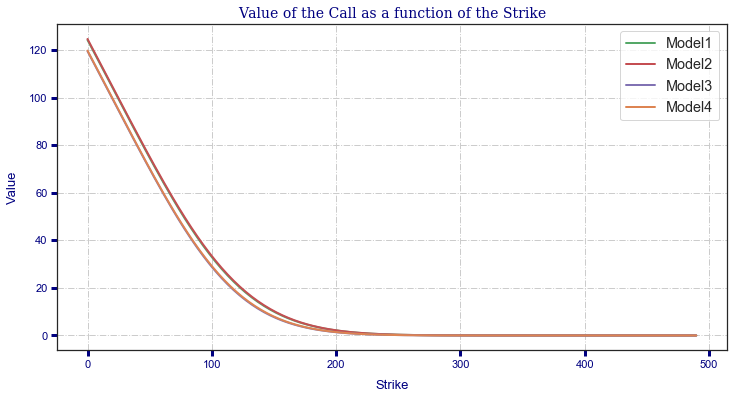

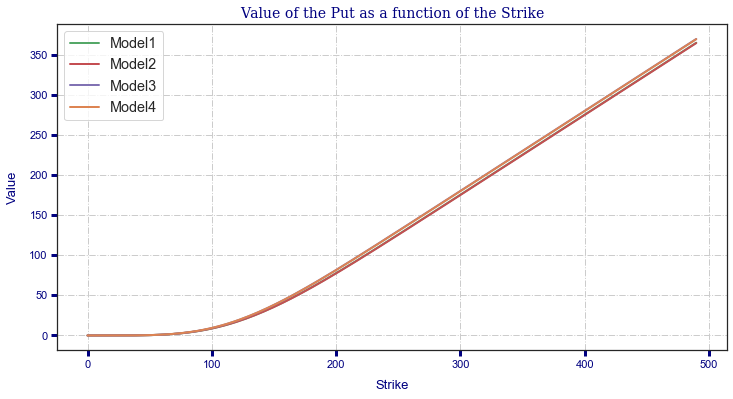

Value of the quantiles [0.001, 0.005, 0.01, 0.99, 0.995, 0.999] : 

Model 1 : 
[ 19.01705923  28.81279514  34.61820227 257.74542296 274.02620796
 310.81937198]
Model 2 : 
[ 18.41547391  27.9793603   33.66402828 257.97864496 274.63218093
 311.56078084]
Model 3 : 
[ 19.20555259  28.89802386  34.31353941 243.33719667 259.469436
 293.02081878]
Model 4 : 
[ 18.95289684  28.51969541  34.00482876 244.62107353 260.86041295
 292.50004645]


In [310]:
Results([HDDValues9, HDDValues10, HDDValues11, HDDValues12], 'HDD Index', 'Jun - Aug')

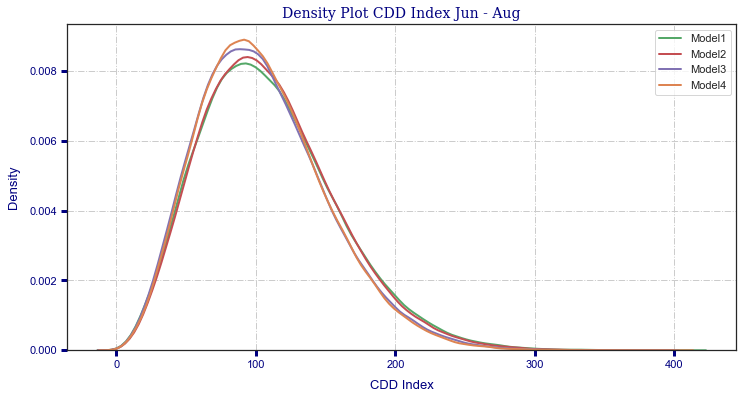

Value of the Future for Model1 : 109.43722114269686
Value of the Future for Model2 : 109.2902872336465
Value of the Future for Model3 : 104.88865529124658
Value of the Future for Model4 : 104.70837983662497


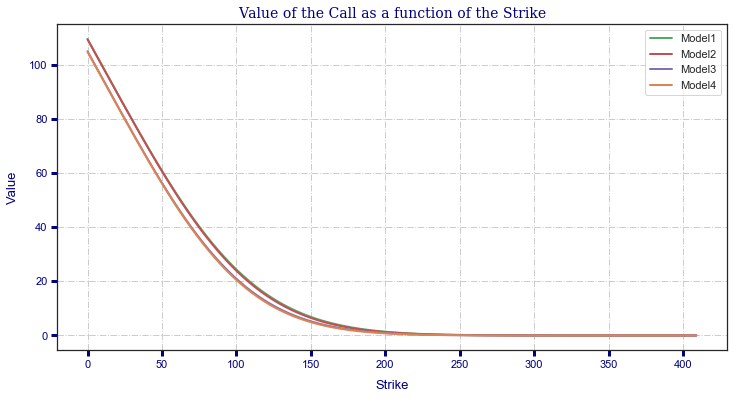

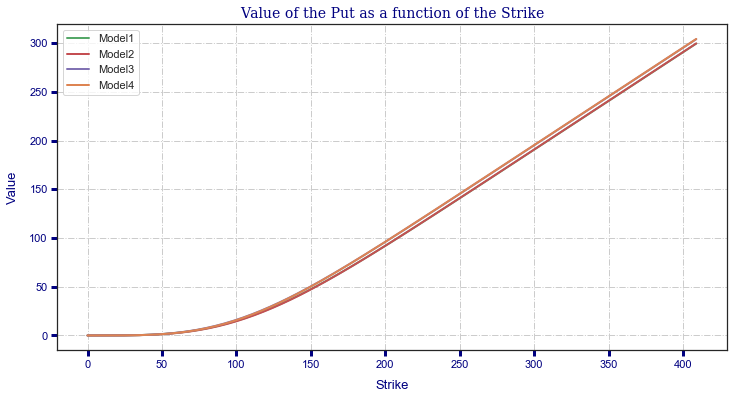

Value of the quantiles [0.001, 0.005, 0.01, 0.99, 0.995, 0.999] : 

Model 1 : 
[  8.41648348  16.01666246  20.6827988  245.48423859 263.5976838
 299.68740444]
Model 2 : 
[  8.85632575  16.99918431  21.97217954 242.60130413 260.17977011
 295.78584072]
Model 3 : 
[  8.88046318  16.26303396  20.98563709 233.06215379 248.67527429
 283.21620104]
Model 4 : 
[  8.73493605  16.48756395  21.52298508 228.80825735 244.80730727
 279.47684225]


In [304]:
Results([CDDValues9, CDDValues10, CDDValues11, CDDValues12], 'CDD Index', 'Jun - Aug')

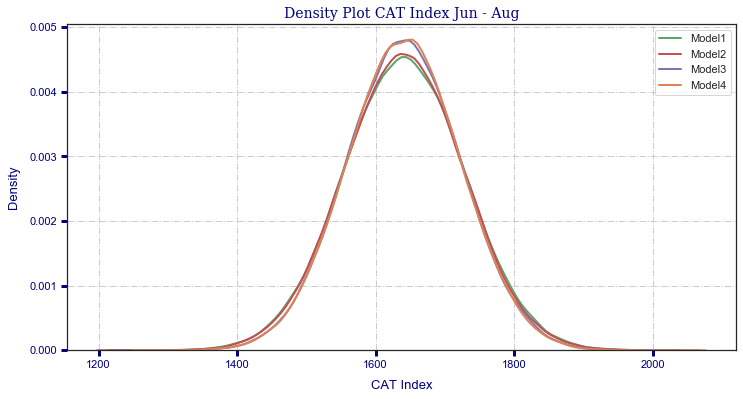

Value of the Future for Model1 : 1641.1927725497994
Value of the Future for Model2 : 1640.7719777509606
Value of the Future for Model3 : 1641.2077110364737
Value of the Future for Model4 : 1640.9496469111166


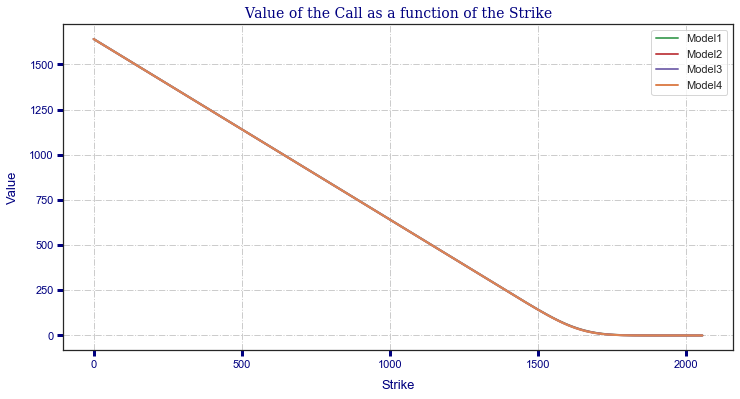

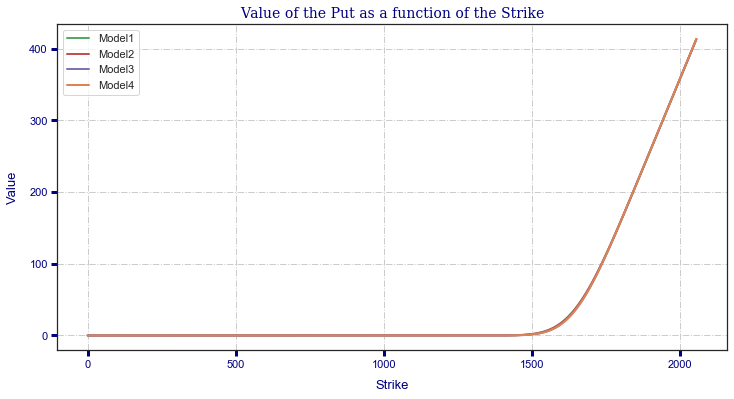

Value of the quantiles [0.001, 0.005, 0.01, 0.99, 0.995, 0.999] : 

Model 1 : 
[1369.47142058 1414.2824245  1436.94262412 1845.55201705 1868.01779751
 1912.71163903]
Model 2 : 
[1370.93340808 1415.89348602 1437.5374029  1843.65200822 1866.51066175
 1913.82550884]
Model 3 : 
[1389.00145963 1429.36295857 1449.37317579 1833.71112824 1854.86029378
 1895.76244251]
Model 4 : 
[1385.65855366 1429.62142789 1449.23487872 1831.88107083 1852.51758937
 1892.00465676]


In [303]:
Results([CatValues9, CatValues10, CatValues11, CatValues12], 'CAT Index', 'Jun - Aug')

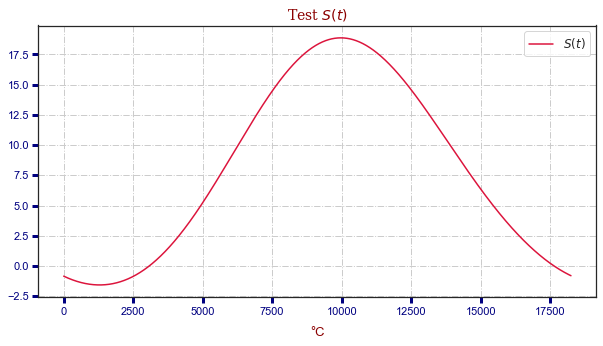

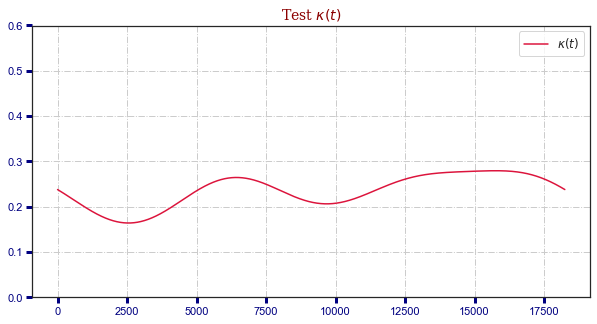

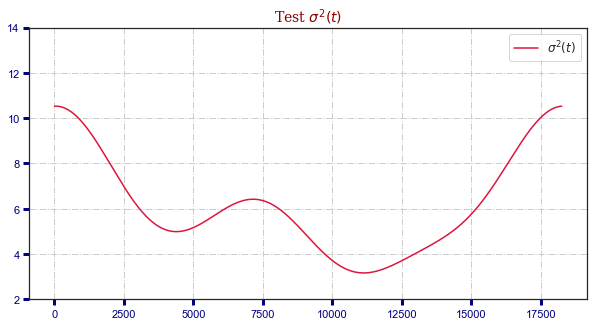

In [19]:
@njit
def Test(t, Maturity, InitialDiff, nDailySteps, nSim):
    dT = 1/nDailySteps
    def Strend(t):
        omega = 2*np.pi/365.0
        alpha = 6.1785162890049445
        beta = 9.842711993555477e-05
        theta1 = 10.17684885383261
        phi1 = -1.9358915022293823
        theta2 = -0.7672813386695645
        phi2 =  29.623776422246006
        value = alpha + beta*t + theta1*np.sin(omega*t+phi1) + theta2*np.sin(2*omega*t+phi2)
        return value
    def Kappa(t):
        omega = 2*np.pi/365.0
        Lambda = 0.23523671259171378
        phi1 = -0.029629918020637566
        varphi1 = 0.06496097376065202
        phi2 = -0.036865297056646366
        varphi2 = 0.26830186964048086
        phi3 = 0.01633859377487671
        varphi3 = 1.6017102936767609
        phi4 = -0.0007695873912343463
        varphi4 = 0.24609306152333735
        return Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4)
    def SigmaSquarred(t):
        omega = 2*np.pi/365.0
        Lambda = 6.137261912748916
        phi1 = 2.4610598949596327
        varphi1 = 1.2648519932150053
        phi2 = -1.6420730958940173
        varphi2 = -1.1105401910897663
        phi3 = 0.6901859440955523
        varphi3 = 0.8159967383683336
        phi4 = -0.0859968526532975
        varphi4 = -0.7976238695231654
        return Lambda + phi1*np.sin(omega*t+varphi1) + phi2*np.sin(2*omega*t+varphi2) + phi3*np.sin(3*omega*t+varphi3) + phi4*np.sin(4*omega*t+varphi4)
    def path():        
        N = Maturity*nDailySteps
        vS = np.zeros(shape = N + 1)
        vKappa = np.zeros(shape = N + 1)
        vSigma = np.zeros(shape = N + 1)
        for i in prange(N + 1):
            vS[i] = Strend(t + i*dT)
            vKappa[i] = Kappa(t + i*dT)
            vSigma[i] = SigmaSquarred(t + i*dT)
        test = vS, vKappa, vSigma
        return test
    return path()

test = Test(t = 18251, Maturity = 365, InitialDiff = -6.761597896470001, nDailySteps = 50, nSim = 100)
vS, vKappa, vSigma = test
#Plot S(t)
fig, ax = plt.subplots(figsize=(10,5))
plt.title(r"Test $S(t)$", fontdict = font)
ax.set_xlabel('°C', rotation='horizontal', color='darkred', size = 13, labelpad=10)
plt.plot(vS, color='crimson', label = r"$S(t)$")        
plt.legend(fontsize = 'large', loc = 'upper right')
plt.show()
fig.savefig('C:/Users/nicol/Dropbox/Mémoire/Tempfig/TestSt.pdf', bbox_inches='tight')
#Plot Kappa(t)
fig, ax = plt.subplots(figsize=(10,5))
plt.title(r"Test $\kappa (t)$", fontdict = font)
plt.plot(vKappa, color='crimson', label = r"$\kappa (t)$")        
plt.legend(fontsize = 'large', loc = 'upper right')
plt.ylim((0.0, 0.6))
plt.show()
fig.savefig('C:/Users/nicol/Dropbox/Mémoire/Tempfig/Kappa.pdf', bbox_inches='tight')
#Plot sigma(t)
fig, ax = plt.subplots(figsize=(10,5))
plt.title(r"Test $\sigma^2(t)$", fontdict = font)
plt.plot(vSigma, color='crimson', label = r"$\sigma^2(t)$")        
plt.legend(fontsize = 'large', loc = 'upper right')
plt.ylim((2, 14))
plt.show()
fig.savefig('C:/Users/nicol/Dropbox/Mémoire/Tempfig/TestSigma.pdf', bbox_inches='tight')

In [95]:
def npTEST(Nsim, Delta_t, Lambda, alpha, beta):
    Varray = np.zeros(Nsim)
    start_time = time.time()
    N = np.random.normal(loc=0.0, scale=1.0, size=Nsim)
    print("Normal")
    print("Mean : " +str(N.mean()))
    print("Var : " +str(N.var()))
    X = scs.gamma.rvs(a = Lambda*Delta_t, loc = 0, scale = 2/(alpha**2 - beta**2), size=Nsim)
    #X = np.random.gamma(shape = Lambda*Delta_t, scale = 1/np.sqrt(alpha**2 - beta**2), size=Nsim)
    print("gamma")
    print("Mean : " +str(X.mean()))
    print("Var : " +str(X.var()))
    Varray = beta*X + np.sqrt(X) * N
    PrintStr = "Running time :  {}\n"
    print(PrintStr.format(str(time.time() - start_time)))
    #print("time.time() - start_time)
    return Varray

test5 = npTEST(Nsim = 10000000, Delta_t = 0.1, Lambda = 3.020783, alpha = 2.458418, beta = 1.681182e-05)

print(test5.mean())
print(test5.var())

Normal
Mean : -0.0005640363211321201
Var : 1.0006494074232235
gamma
Mean : 0.09997970928673806
Var : 0.03306650592231776
Running time :  3.4149370193481445

-2.4168810832076194e-05
0.10010242642710644


In [100]:
Lambda = 3.020783 *0.1
alpha = 2.458418
beta = 1.681182e-05
gamma = np.sqrt(alpha**2 - beta**2)
GammaScale = 2/(alpha**2 - beta**2)

#gamma 
print("gamma test")
print("Mean : " +str(Lambda*GammaScale))
print("Var : " +str(Lambda*GammaScale**2))

#Variance gamma 
print("VG test")
print("Mean : " +str(2*beta*Lambda/gamma))

#variance
print("var : " + str((2*Lambda/(gamma**2))*(1 + (2*(beta/gamma)**2))))
print("var : " + str((2*Lambda/gamma**2 ) + 4*Lambda*beta**2/(gamma**4)))


gamma test
Mean : 0.09996272121289394
Var : 0.033079322918219405
VG test
Mean : 4.131507339780905e-06
var : 0.09996272122224338
var : 0.09996272122224338
